<a href="https://colab.research.google.com/github/yakaralar/IE492/blob/master/Meta_last_version_to_be_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import glob
import shutil
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
absolute_path="drive/My Drive/IE 492"

In [ ]:
#os.listdir("drive/My Drive/kubi_preds")
os.listdir(absolute_path+"/kubi_preds")

['LR_2.csv',
 'naive_2.csv',
 'LR_2_7_w_dates.csv',
 'naive_7.csv',
 'LR_2_7.csv',
 'LR_7.csv',
 'ygur_rima_preds_datetime.csv',
 'eval_plots',
 'Cat1_48hours.csv',
 'Cat2_categorical_48hours.csv',
 'Cat1_24hours.csv',
 'Cat2_categorical_24hours.csv',
 'Keras_Basic_dense_24.csv',
 'Keras_Basic_dense_48.csv',
 'HW_26.05_15.17_48.csv',
 'HW_26.05_15.17_24.csv']

In [ ]:
shutil.copy(absolute_path+"/RealTimeConsumption_unholidayized.csv","./")
shutil.copy(absolute_path+"/RealTimeConsumption-01122014-09032020.csv","./")
shutil.copy(absolute_path+"/RealTimeConsumption_holiday.csv","./")
shutil.copy(absolute_path+"/kubi_temp_humid_wind_data_20151231-2020-04-02.csv","./")

'./kubi_temp_humid_wind_data_20151231-2020-04-02.csv'

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

%matplotlib inline
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### eval func

In [ ]:
!pip install graphviz
!pip install sklearn --upgrade
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,plot_tree

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df=[]
def eval_function(name_,y_true, y_pred,valid_df):
    """
    name_:kullanılan modelin ismi
    y_true:actual values
    y_pred:predicted values
    valid_df:modele verdiginiz sekliyle validation dataframe'i ve yanına datetime'ı
    """
    ap="drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/"+name_
    if not os.path.exists(ap):
        os.mkdir(ap)
    rmse_=np.sqrt(mean_squared_error(y_true,y_pred))
    rmsle_=np.sqrt(mean_squared_log_error(y_true,y_pred))
    mae_=mean_absolute_error(y_true,y_pred)
    mape_=mean_absolute_percentage_error(y_true, y_pred)
    mapes_each_period=[mean_absolute_percentage_error(y_true[i],y_pred[i]) for i in range(len(y_true))]
    mapes_each_period=pd.DataFrame(mapes_each_period,columns=["mapes"])
    mapes_each_period["Datetime"]=valid_df["Datetime"].iloc[-len(mapes_each_period):]
    print("RMSE: ",rmse_)
    print("RMSLE: ",rmsle_)
    print("MAE: ",mae_)
    print("MAPE: ",mape_)
    fig=plt.figure(figsize=(16,10))
    sns.scatterplot(x=y_pred,y=y_true)
    fig.savefig("drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/"+name_+"/actual_vs_predicted.png")
    plt.pause(0.01)
    fig=plt.figure(figsize=(16,10))
    sns.residplot(y_true,y_pred)
    plt.pause(0.01)
    fig.savefig("drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/"+name_+"/residplot.png")
    nchunks=6 # plot count
    fig,ax=plt.subplots(nrows=32,figsize=(32,125))
    valid_copy=valid_df.reset_index(drop=True).copy()

    for i,datetime_ in enumerate(np.array_split(valid_copy["Datetime"],32)):
        sns.lineplot(y=y_true[datetime_.index.tolist()],x=datetime_,color="green",ax=ax[i])
        sns.lineplot(y=y_pred[datetime_.index.tolist()],x=datetime_,color="red",ax=ax[i])
    fig.savefig("drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/"+name_+"/lineplot_pred_act_{}.png".format(i))

    fig,ax=plt.subplots(nrows=nchunks,figsize=(32,25))
    for i,datetime_ in enumerate(np.array_split(mapes_each_period,nchunks)):
        sns.lineplot(y="mapes",x="Datetime",data=datetime_,ax=ax[i])
    fig.savefig("drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/"+name_+"/lineplot_errors.png")

    # plt.pause(0.01)
    # res_model=DecisionTreeRegressor(max_depth=4)
    # _, ax = plt.subplots(figsize=(60, 60))  # whatever size you want
    # fig=res_model.fit(valid_df.drop(columns=["Datetime"]),y_true-y_pred)
    # plot_tree(fig,ax=ax,feature_names=valid_df.drop(columns=["Datetime"]).columns,fontsize=16)
    # plt.pause(0.01)
    # ## saatlik mape tanımla
    return name_, rmse_,rmsle_,mae_,mape_

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


### Consumption df

In [ ]:
# # bruuuuuuuh
# cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
# cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
# cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
# cons_holiday_binary.head()

In [ ]:
# catboostu 1 aylık yap

In [ ]:
preds_paths=glob.glob(absolute_path+"/kubi_preds/*.csv")
preds_paths

['drive/My Drive/IE 492/kubi_preds/LR_2.csv',
 'drive/My Drive/IE 492/kubi_preds/naive_2.csv',
 'drive/My Drive/IE 492/kubi_preds/LR_2_7_w_dates.csv',
 'drive/My Drive/IE 492/kubi_preds/naive_7.csv',
 'drive/My Drive/IE 492/kubi_preds/LR_2_7.csv',
 'drive/My Drive/IE 492/kubi_preds/LR_7.csv',
 'drive/My Drive/IE 492/kubi_preds/ygur_rima_preds_datetime.csv',
 'drive/My Drive/IE 492/kubi_preds/Cat1_48hours.csv',
 'drive/My Drive/IE 492/kubi_preds/Cat2_categorical_48hours.csv',
 'drive/My Drive/IE 492/kubi_preds/Cat1_24hours.csv',
 'drive/My Drive/IE 492/kubi_preds/Cat2_categorical_24hours.csv',
 'drive/My Drive/IE 492/kubi_preds/Keras_Basic_dense_24.csv',
 'drive/My Drive/IE 492/kubi_preds/Keras_Basic_dense_48.csv',
 'drive/My Drive/IE 492/kubi_preds/HW_26.05_15.17_48.csv',
 'drive/My Drive/IE 492/kubi_preds/HW_26.05_15.17_24.csv']

In [ ]:
#a=pd.read_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/ygur_rima_preds_datetime.csv")
#a["Datetime"]=pd.to_datetime(a["Datetime"],format="%d/%m/%Y %H:%M")
#a=a.iloc[:,:-1]
#a.columns=["Datetime","Arima"]
#a.to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/ygur_rima_preds_datetime.csv",index=False)

In [ ]:
#path_="drive/My Drive/colab_datas/IE 492/kubi_preds/erdem_HW_preds_new.csv"
#a=pd.read_csv(path_)
#a["Datetime"]=pd.to_datetime(a["Datetime"])
#a.loc[a["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")][["Datetime","HW_unhol_reg"]].to_csv(path_,index=False)

In [ ]:
pred_dfs=[]

for i,path_ in enumerate(preds_paths):
    df=pd.read_csv(path_)
   # if "HW" in path_:
    #    df=df.loc[df["Datetime"].between('2019-02-01','2020-03-05')].reset_index(drop=True)
    #elif "rima" in path_:
    
    #    df["Datetime"]=pd.date_range('2019-02-01','2020-03-04',freq="H")[:-1]
    df.columns=["Datetime_"+str(i),path_.split("/")[-1].strip(".csv")]
    pred_dfs.append(df)
preds=pd.concat(pred_dfs,axis=1)
preds = preds.drop(columns = ["Cat1_24hour", "Cat2_categorical_24hour", "Keras_Basic_dense_24", "HW_26.05_15.17_24"])

In [ ]:
preds=preds[["Datetime_0"]+[i for i in preds.columns if not i.startswith("Datetime")]].rename(columns={"Datetime_0":"Datetime"})
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371
...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223


In [ ]:
shutil.copy(absolute_path+"/Consumption_special_days_v2.csv","./")

'./Consumption_special_days_v2.csv'

In [ ]:
# bruuuuuuuh
cons_holiday_binary=pd.read_csv("Consumption_special_days_v2.csv",encoding='latin-1')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary

,Date,Hour,Consumption,Datetime,is_religious_holiday,is_normal_holiday,is_special_day
0,31.12.2015,00:00,29590.88,2015-12-31 00:00:00,0,1,0
1,31.12.2015,01:00,27785.43,2015-12-31 01:00:00,0,1,0
2,31.12.2015,02:00,26516.53,2015-12-31 02:00:00,0,1,0
3,31.12.2015,03:00,26091.62,2015-12-31 03:00:00,0,1,0
4,31.12.2015,04:00,25871.54,2015-12-31 04:00:00,0,1,0
...,...,...,...,...,...,...,...
36571,03.03.2020,19:00,37936.79,2020-03-03 19:00:00,0,0,0
36572,03.03.2020,20:00,37553.37,2020-03-03 20:00:00,0,0,0
36573,03.03.2020,21:00,36581.73,2020-03-03 21:00:00,0,0,0
36574,03.03.2020,22:00,35434.36,2020-03-03 22:00:00,0,0,0


In [ ]:
##for plotting
data = cons_holiday_binary.drop(["Date", "Hour", "is_religious_holiday", "is_normal_holiday", "is_special_day"], axis = 1)
data1 = data[data.Datetime < "01.02.2016 00:00:00"]

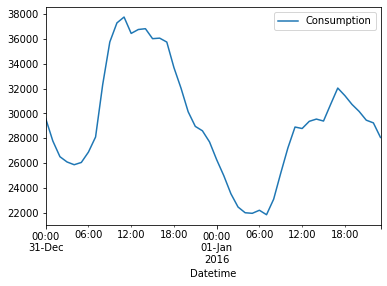

In [ ]:
data1.plot(x = "Datetime", y = "Consumption")

In [ ]:
preds["reel"]=cons_holiday_binary.loc[cons_holiday_binary["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")][["Consumption"]].values
preds.Datetime=pd.to_datetime(preds.Datetime)
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36


In [ ]:
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:

mapes={}
calc_mapes=preds.set_index("Datetime")
for model_name in calc_mapes.columns[:-1]:
    y_true,y_pred=calc_mapes[["reel",model_name]].values.T
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    mapes[model_name]=mape_
pd.DataFrame([list(mapes.keys()),list(mapes.values())]).T.sort_values(1)

,0,1
7,Cat1_48hour,2.99118
8,Cat2_categorical_48hour,3.24907
6,ygur_rima_preds_datetime,3.46533
9,Keras_Basic_dense_48,3.68307
10,HW_26.05_15.17_48,3.89177
2,LR_2_7_w_date,4.05324
4,LR_2_7,4.98923
3,naive_7,5.20805
5,LR_7,5.22779
0,LR_2,7.85569


In [ ]:
## 5 iq move düzelt bunu
best_models=[]
for i,row in preds.iterrows():
    best_mape=999999
    best_model=""
    for col in preds.columns.difference(["Datetime","reel"]):
        mape_=mean_absolute_percentage_error(row["reel"],row[col])
        if best_mape>mape_:
            best_mape=mape_
            best_model=col
    best_models.append(best_model)
preds["best_model"]=best_models
len(preds)+1

9529

In [ ]:
mapes["best_case"]=preds.loc[preds["best_model"]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x["best_model"]]),axis=1).mean()

In [ ]:
mapes

{'Cat1_48hour': 2.991182739400095,
 'Cat2_categorical_48hour': 3.2490686862665186,
 'HW_26.05_15.17_48': 3.89177361329798,
 'Keras_Basic_dense_48': 3.683070359734644,
 'LR_2': 7.855694573000102,
 'LR_2_7': 4.989226864853979,
 'LR_2_7_w_date': 4.053236198257791,
 'LR_7': 5.22779264475642,
 'best_case': 0.8467312948835701,
 'naive_2': 8.15891679451568,
 'naive_7': 5.208054715113833,
 'ygur_rima_preds_datetime': 3.4653294353157422}

In [ ]:
def brute_meta(n,buffer):
    shift_timespan=n*24
    chosen_models=["unknown"]*(shift_timespan+buffer)
    print("meta brute with n = {}, buffer = {}".format(n,buffer))
    for i in tqdm(range(shift_timespan,len(preds))):
        ## buraya prob koyacaggız
        chosen_models.append(preds["best_model"].iloc[i-shift_timespan:i].value_counts().index[0])
    preds["chosen"]=chosen_models[:len(chosen_models)-buffer]
    mapes_brute=preds.loc[preds["chosen"]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x["chosen"]]),axis=1)
    mapes["window_{}_days_{}_buffer".format(n,buffer)]=mapes_brute.mean()
    print(mapes_brute.mean())

In [ ]:
# with open("a.py","w") as file:
#     file.write("import this")
# %run a.py

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
combins=np.concatenate([[(j,i) for i in [0,24,48]] for j in [5,7,14,28,30]])
for n,buffer in combins:
    brute_meta(n,buffer)

  1%|          | 92/9408 [00:00<00:10, 915.83it/s]

meta brute with n = 5, buffer = 0


  1%|          | 92/9408 [00:00<00:10, 916.86it/s]

3.508829558454778
meta brute with n = 5, buffer = 24


  1%|          | 91/9408 [00:00<00:10, 902.13it/s]

3.9236702765739047
meta brute with n = 5, buffer = 48


  1%|          | 90/9360 [00:00<00:10, 890.78it/s]

3.7879867430383993
meta brute with n = 7, buffer = 0


  1%|          | 90/9360 [00:00<00:10, 899.17it/s]

3.189332706524515
meta brute with n = 7, buffer = 24


  1%|          | 90/9360 [00:00<00:10, 892.24it/s]

3.411063823154682
meta brute with n = 7, buffer = 48


  2%|▏         | 174/9192 [00:00<00:10, 875.34it/s]

3.4924903013257618
meta brute with n = 14, buffer = 0


  1%|          | 89/9192 [00:00<00:10, 884.55it/s]

3.165183421614112
meta brute with n = 14, buffer = 24


  2%|▏         | 175/9192 [00:00<00:10, 861.34it/s]

3.3433328152997355
meta brute with n = 14, buffer = 48


  1%|          | 86/8856 [00:00<00:10, 857.57it/s]

3.3379963659607985
meta brute with n = 28, buffer = 0


  1%|          | 98/8856 [00:00<00:08, 979.83it/s]

3.1847399389382884
meta brute with n = 28, buffer = 24


  1%|          | 86/8856 [00:00<00:10, 858.99it/s]

3.261370167661324
meta brute with n = 28, buffer = 48


  1%|          | 87/8808 [00:00<00:10, 866.71it/s]

3.298430334331218
meta brute with n = 30, buffer = 0


  1%|          | 86/8808 [00:00<00:10, 858.44it/s]

3.1990818838070467
meta brute with n = 30, buffer = 24


  1%|          | 84/8808 [00:00<00:10, 833.27it/s]

3.2573839206082127
meta brute with n = 30, buffer = 48


100%|██████████| 8808/8808 [00:10<00:00, 870.32it/s]


3.2284847330660833


In [ ]:
mapes

{'Cat1_48hour': 2.991182739400095,
 'Cat2_categorical_48hour': 3.2490686862665186,
 'HW_26.05_15.17_48': 3.89177361329798,
 'Keras_Basic_dense_48': 3.683070359734644,
 'LR_2': 7.855694573000102,
 'LR_2_7': 4.989226864853979,
 'LR_2_7_w_date': 4.053236198257791,
 'LR_7': 5.22779264475642,
 'best_case': 0.8467312948835701,
 'naive_2': 8.15891679451568,
 'naive_7': 5.208054715113833,
 'window_14_days_0_buffer': 3.165183421614112,
 'window_14_days_24_buffer': 3.3433328152997355,
 'window_14_days_48_buffer': 3.3379963659607985,
 'window_28_days_0_buffer': 3.1847399389382884,
 'window_28_days_24_buffer': 3.261370167661324,
 'window_28_days_48_buffer': 3.298430334331218,
 'window_30_days_0_buffer': 3.1990818838070467,
 'window_30_days_24_buffer': 3.2573839206082127,
 'window_30_days_48_buffer': 3.2284847330660833,
 'window_5_days_0_buffer': 3.508829558454778,
 'window_5_days_24_buffer': 3.9236702765739047,
 'window_5_days_48_buffer': 3.7879867430383993,
 'window_7_days_0_buffer': 3.1893327065

##### Sunum için örnek

In [ ]:
nisan_24=preds.loc[preds["Datetime"].between(pd.to_datetime("2019-04-24 00:00:00"),pd.to_datetime("2019-04-25 00:00:00"))]
day_by_day_sort={}
for i,row in nisan_24.iterrows():
    mapes_a={}
    for col in nisan_24.columns[1:11]:
        mape_=mean_absolute_percentage_error(row["reel"],row[col])
        mapes_a[col]=mape_
    day_by_day_sort[row["Datetime"]]=mapes_a
day_by_day_sort

{Timestamp('2019-04-24 00:00:00'): {'Cat1_48hour': 3.2550492638705992,
  'Cat2_categorical_48hour': 4.0141117858170565,
  'Keras_Basic_dense_48': 7.213321168131337,
  'LR_2': 1.8654968712021158,
  'LR_2_7': 4.078852493495687,
  'LR_2_7_w_date': 3.7699078135235085,
  'LR_7': 6.957455676398823,
  'naive_2': 1.3105580265177919,
  'naive_7': 6.193579003332738,
  'ygur_rima_preds_datetime': 6.636509101465669},
 Timestamp('2019-04-24 01:00:00'): {'Cat1_48hour': 4.149418695961482,
  'Cat2_categorical_48hour': 3.9536312716998854,
  'Keras_Basic_dense_48': 7.046823417381996,
  'LR_2': 2.948258726195324,
  'LR_2_7': 4.214070795705579,
  'LR_2_7_w_date': 4.332855355359548,
  'LR_7': 7.993531180302443,
  'naive_2': 2.02019839323456,
  'naive_7': 6.291836117680087,
  'ygur_rima_preds_datetime': 6.5047205108557495},
 Timestamp('2019-04-24 02:00:00'): {'Cat1_48hour': 3.224480103978185,
  'Cat2_categorical_48hour': 3.527110735605522,
  'Keras_Basic_dense_48': 5.718579274491101,
  'LR_2': 3.50261943950

In [ ]:
pd.DataFrame.from_dict(day_by_day_sort).to_csv("24_nisan_sorted.csv")

In [ ]:
{key:pd.DataFrame.from_dict(day_by_day_sort[key],orient="index").sort_values(by=0).index.tolist() for key in day_by_day_sort.keys() }

{Timestamp('2019-04-24 00:00:00'): ['naive_2',
  'LR_2',
  'Cat1_48hour',
  'LR_2_7_w_date',
  'Cat2_categorical_48hour',
  'LR_2_7',
  'naive_7',
  'ygur_rima_preds_datetime',
  'LR_7',
  'Keras_Basic_dense_48'],
 Timestamp('2019-04-24 01:00:00'): ['naive_2',
  'LR_2',
  'Cat2_categorical_48hour',
  'Cat1_48hour',
  'LR_2_7',
  'LR_2_7_w_date',
  'naive_7',
  'ygur_rima_preds_datetime',
  'Keras_Basic_dense_48',
  'LR_7'],
 Timestamp('2019-04-24 02:00:00'): ['naive_2',
  'Cat1_48hour',
  'LR_2',
  'Cat2_categorical_48hour',
  'LR_2_7',
  'LR_2_7_w_date',
  'naive_7',
  'ygur_rima_preds_datetime',
  'Keras_Basic_dense_48',
  'LR_7'],
 Timestamp('2019-04-24 03:00:00'): ['Cat1_48hour',
  'naive_2',
  'Cat2_categorical_48hour',
  'LR_2_7',
  'LR_2',
  'LR_2_7_w_date',
  'Keras_Basic_dense_48',
  'ygur_rima_preds_datetime',
  'naive_7',
  'LR_7'],
 Timestamp('2019-04-24 04:00:00'): ['Cat1_48hour',
  'naive_2',
  'Cat2_categorical_48hour',
  'LR_2_7',
  'LR_2_7_w_date',
  'LR_2',
  'naive_7

In [ ]:
pd.DataFrame.from_dict({key:pd.DataFrame.from_dict(day_by_day_sort[key],orient="index").sort_values(by=0).index.tolist() for key in day_by_day_sort.keys() }).T

,0,1,2,3,4,5,6,7,8,9
2019-04-24 00:00:00,naive_2,LR_2,Cat1_48hour,LR_2_7_w_date,Cat2_categorical_48hour,LR_2_7,naive_7,ygur_rima_preds_datetime,LR_7,Keras_Basic_dense_48
2019-04-24 01:00:00,naive_2,LR_2,Cat2_categorical_48hour,Cat1_48hour,LR_2_7,LR_2_7_w_date,naive_7,ygur_rima_preds_datetime,Keras_Basic_dense_48,LR_7
2019-04-24 02:00:00,naive_2,Cat1_48hour,LR_2,Cat2_categorical_48hour,LR_2_7,LR_2_7_w_date,naive_7,ygur_rima_preds_datetime,Keras_Basic_dense_48,LR_7
2019-04-24 03:00:00,Cat1_48hour,naive_2,Cat2_categorical_48hour,LR_2_7,LR_2,LR_2_7_w_date,Keras_Basic_dense_48,ygur_rima_preds_datetime,naive_7,LR_7
2019-04-24 04:00:00,Cat1_48hour,naive_2,Cat2_categorical_48hour,LR_2_7,LR_2_7_w_date,LR_2,naive_7,Keras_Basic_dense_48,ygur_rima_preds_datetime,LR_7
2019-04-24 05:00:00,Cat1_48hour,naive_2,LR_2_7,LR_2,Cat2_categorical_48hour,LR_2_7_w_date,naive_7,ygur_rima_preds_datetime,Keras_Basic_dense_48,LR_7
2019-04-24 06:00:00,naive_2,Cat1_48hour,LR_2_7,Cat2_categorical_48hour,LR_2,LR_2_7_w_date,naive_7,Keras_Basic_dense_48,ygur_rima_preds_datetime,LR_7
2019-04-24 07:00:00,naive_2,Cat1_48hour,Cat2_categorical_48hour,LR_2,LR_2_7,Keras_Basic_dense_48,LR_2_7_w_date,ygur_rima_preds_datetime,naive_7,LR_7
2019-04-24 08:00:00,Cat2_categorical_48hour,Cat1_48hour,Keras_Basic_dense_48,LR_2,naive_2,LR_2_7,LR_2_7_w_date,LR_7,ygur_rima_preds_datetime,naive_7
2019-04-24 09:00:00,Cat2_categorical_48hour,Cat1_48hour,LR_2_7_w_date,LR_2_7,naive_2,Keras_Basic_dense_48,LR_7,ygur_rima_preds_datetime,LR_2,naive_7


In [ ]:
mapes

{'Cat1_48hour': 2.991182739400095,
 'Cat2_categorical_48hour': 3.2490686862665186,
 'HW_26.05_15.17_48': 3.89177361329798,
 'Keras_Basic_dense_48': 3.683070359734644,
 'LR_2': 7.855694573000102,
 'LR_2_7': 4.989226864853979,
 'LR_2_7_w_date': 4.053236198257791,
 'LR_7': 5.22779264475642,
 'best_case': 0.8467312948835701,
 'naive_2': 8.15891679451568,
 'naive_7': 5.208054715113833,
 'ygur_rima_preds_datetime': 3.4653294353157422}

In [ ]:
pd.DataFrame.from_dict(mapes,orient="index").to_excel("Mapes.xlsx")

In [ ]:
# preds.loc[1344,"Datetime"]=pd.to_datetime("2019-03-29 00:00:00")

## decision tree

In [ ]:
shutil.copy(absolute_path+"/Consumption_special_days_v2.csv","./")
cons_holiday_binary  = pd.read_csv('Consumption_special_days_v2.csv')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()


,Date,Hour,Consumption,Datetime,is_religious_holiday,is_normal_holiday,is_special_day
0,31.12.2015,00:00,29590.88,2015-12-31 00:00:00,0,1,0
1,31.12.2015,01:00,27785.43,2015-12-31 01:00:00,0,1,0
2,31.12.2015,02:00,26516.53,2015-12-31 02:00:00,0,1,0
3,31.12.2015,03:00,26091.62,2015-12-31 03:00:00,0,1,0
4,31.12.2015,04:00,25871.54,2015-12-31 04:00:00,0,1,0


In [ ]:
weather_data=pd.read_csv('kubi_temp_humid_wind_data_20151231-2020-04-02.csv')
weather_data=weather_data.rename(columns={"rounded_date":"Datetime"})
weather_data["Datetime"]=pd.to_datetime(weather_data["Datetime"])
cons_holiday_binary=pd.merge(cons_holiday_binary,weather_data,on="Datetime",how="left")
cat_df_1=cons_holiday_binary[["Datetime"] + [i for i in cons_holiday_binary.columns if i.startswith("is_")]].copy()
cat_df_1["Hour"]=cat_df_1["Datetime"].apply(lambda x:x.hour).astype(int)
cat_df_1["Day"]=cat_df_1["Datetime"].apply(lambda x:x.day).astype(int)
cat_df_1["Month"]=cat_df_1["Datetime"].apply(lambda x:x.month).astype(int)
cat_df_1["weekday"]=cat_df_1["Datetime"].apply(lambda x: x.weekday()).astype(int)
cat_df_1.head()

,Datetime,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday
0,2015-12-31 00:00:00,0,1,0,0,31,12,3
1,2015-12-31 01:00:00,0,1,0,1,31,12,3
2,2015-12-31 02:00:00,0,1,0,2,31,12,3
3,2015-12-31 03:00:00,0,1,0,3,31,12,3
4,2015-12-31 04:00:00,0,1,0,4,31,12,3


In [ ]:
np.unique([i.split("_")[1] for i in weather_data.columns if i!="Datetime"])

array(['Adana / Incirlik', 'Adana / Sakirpasa', 'Afyon', 'Akhisar',
       'Ankara / Esenboga', 'Ankara / Etimesgut', 'Antalya', 'Aydin',
       'Balikesir', 'Bandirma', 'Batman', 'Bodrum', 'Canakkale',
       'Dalaman', 'Diyarbakir', 'Elazig', 'Erzincan', 'Erzurum',
       'Eskisehir', 'Gaziantep', 'Iskenderun', 'Isparta',
       'Isparta / Gölba??', 'Istanbul / Ataturk',
       'Izmir / Adnan Menderes', 'Izmir / Cigli', 'Kars',
       'Kayseri / Erkilet', 'Konya', 'Malatya / Erhac', 'Merzifon',
       'Murted Tur-Afb', 'Sivas', 'Tokat', 'Trabzon', 'Usak', 'Van',
       'Zonguldak'], dtype='<U22')

##DECISION TREE farklı değişkenlerle

In [ ]:
preds['var_models'] = preds.iloc[:,1:11].var(axis=1)
preds['mean_models'] = preds.iloc[:,1:11].mean(axis=1)
preds['index']=range(0,len(preds))
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,var_models,mean_models,index
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,9.469347e+04,31668.948816,0
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,1.680739e+05,29852.376811,1
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,1.871761e+05,28670.452944,2
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,2.318003e+05,27982.651825,3
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,2.393240e+05,27816.374851,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,2.784199e+06,37439.988602,9523
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,2.242154e+06,37116.379028,9524
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,1.801375e+06,36256.548537,9525
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,1.381039e+06,35206.134096,9526


Index, model variance, model mean

In [ ]:
from sklearn.tree import DecisionTreeClassifier

shift_timespan=30*24

In [ ]:

primary_predicted_model=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(preds))):
    train_df=preds[["Datetime","best_model",'var_models','mean_models','index']].iloc[:i+48]
    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns=["best_model","Datetime"]))
    # predict proba
    primary_predicted_model.append(pred[0])
preds["primary_tree_predicted"]=primary_predicted_model
mapes=preds.loc[preds["primary_tree_predicted"]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x["primary_tree_predicted"]]),axis=1)
mapes.mean()

100%|██████████| 8808/8808 [06:22<00:00, 23.03it/s]


2.694830994561871

In [ ]:
cat_df_1['Hour'] = cat_df_1['Hour'].astype("category")
cat_df_1['Day'] = cat_df_1['Day'].astype("category")
cat_df_1['Month'] = cat_df_1['Month'].astype("category")
cat_df_1['weekday'] = cat_df_1['weekday'].astype("category")
cat_df_1['is_religious_holiday'] = cat_df_1['is_religious_holiday'].astype("category")
cat_df_1['is_normal_holiday'] = cat_df_1['is_normal_holiday'].astype("category")
cat_df_1['is_special_day'] = cat_df_1['is_special_day'].astype("category")


In [ ]:
cat_df_1

,Datetime,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday
0,2015-12-31 00:00:00,0,1,0,0,31,12,3
1,2015-12-31 01:00:00,0,1,0,1,31,12,3
2,2015-12-31 02:00:00,0,1,0,2,31,12,3
3,2015-12-31 03:00:00,0,1,0,3,31,12,3
4,2015-12-31 04:00:00,0,1,0,4,31,12,3
...,...,...,...,...,...,...,...,...
36571,2020-03-03 19:00:00,0,0,0,19,3,3,1
36572,2020-03-03 20:00:00,0,0,0,20,3,3,1
36573,2020-03-03 21:00:00,0,0,0,21,3,3,1
36574,2020-03-03 22:00:00,0,0,0,22,3,3,1


Index, model variance, model mean, date, special days

In [ ]:
predicted_model_v2=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(preds))):
    train_df=preds[["Datetime","best_model",'var_models','mean_models','index']].iloc[:i+48]
    train_df=pd.merge(train_df,cat_df_1,how="left",on="Datetime")
    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns=["best_model","Datetime"]))
    # predict proba
    predicted_model_v2.append(pred[0])
preds["tree_predicted_2"]=predicted_model_v2
mapes=preds.loc[preds["tree_predicted_2"]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x["tree_predicted_2"]]),axis=1)
mapes.mean()


 43%|████▎     | 3762/8808 [02:42<05:11, 16.22it/s]

KeyboardInterrupt: ignored

Weather ekleme

In [ ]:
shutil.copy(absolute_path+"/weather_turkey_processed.zip","./")
!unzip weather_turkey_processed.zip

Archive:  weather_turkey_processed.zip
replace weather_turkey_processed/36_26.5.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: weather_turkey_processed/36_26.5.csv  
replace weather_turkey_processed/38.5_42.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: weather_turkey_processed/38.5_42.csv  
  inflating: weather_turkey_processed/36_26.csv  
  inflating: weather_turkey_processed/36_27.5.csv  
  inflating: weather_turkey_processed/36_27.csv  
  inflating: weather_turkey_processed/36_28.5.csv  
  inflating: weather_turkey_processed/36_28.csv  
  inflating: weather_turkey_processed/36_29.5.csv  
  inflating: weather_turkey_processed/36_29.csv  
  inflating: weather_turkey_processed/36_30.5.csv  
  inflating: weather_turkey_processed/36_30.csv  
  inflating: weather_turkey_processed/36_31.5.csv  
  inflating: weather_turkey_processed/36_31.csv  
  inflating: weather_turkey_processed/36_32.5.csv  
  inflating: weather_turkey_processed/36_32.csv  
  inflating: weather_tu

In [ ]:
weathers=[]
for path in tqdm(glob.glob("weather_turkey_processed/*.csv")):
    weathers.append(pd.read_csv(path)[['forecast_epoch','lon','lat','TMP_2.m.above.ground']])
weathers=pd.concat(weathers)
weathers["lon_lat"]=weathers["lon"].astype(str)+"_"+weathers["lat"].astype(str)
weathers_pivoted=pd.pivot_table(weathers,index=["forecast_epoch"],columns=["lon_lat"],values=["TMP_2.m.above.ground"])
weathers_pivoted.columns=["temp-"+i[1] for i in weathers_pivoted.columns]

100%|██████████| 507/507 [00:45<00:00, 11.16it/s]


In [ ]:
weathers_pivoted

,temp-26.0_36.0,temp-26.0_36.5,temp-26.0_37.0,temp-26.0_37.5,temp-26.0_38.0,temp-26.0_38.5,temp-26.0_39.0,temp-26.0_39.5,temp-26.0_40.0,temp-26.0_40.5,temp-26.0_41.0,temp-26.0_41.5,temp-26.0_42.0,temp-26.5_36.0,temp-26.5_36.5,temp-26.5_37.0,temp-26.5_37.5,temp-26.5_38.0,temp-26.5_38.5,temp-26.5_39.0,temp-26.5_39.5,temp-26.5_40.0,temp-26.5_40.5,temp-26.5_41.0,temp-26.5_41.5,temp-26.5_42.0,temp-27.0_36.0,temp-27.0_36.5,temp-27.0_37.0,temp-27.0_37.5,temp-27.0_38.0,temp-27.0_38.5,temp-27.0_39.0,temp-27.0_39.5,temp-27.0_40.0,temp-27.0_40.5,temp-27.0_41.0,temp-27.0_41.5,temp-27.0_42.0,temp-27.5_36.0,...,temp-43.5_42.0,temp-44.0_36.0,temp-44.0_36.5,temp-44.0_37.0,temp-44.0_37.5,temp-44.0_38.0,temp-44.0_38.5,temp-44.0_39.0,temp-44.0_39.5,temp-44.0_40.0,temp-44.0_40.5,temp-44.0_41.0,temp-44.0_41.5,temp-44.0_42.0,temp-44.5_36.0,temp-44.5_36.5,temp-44.5_37.0,temp-44.5_37.5,temp-44.5_38.0,temp-44.5_38.5,temp-44.5_39.0,temp-44.5_39.5,temp-44.5_40.0,temp-44.5_40.5,temp-44.5_41.0,temp-44.5_41.5,temp-44.5_42.0,temp-45.0_36.0,temp-45.0_36.5,temp-45.0_37.0,temp-45.0_37.5,temp-45.0_38.0,temp-45.0_38.5,temp-45.0_39.0,temp-45.0_39.5,temp-45.0_40.0,temp-45.0_40.5,temp-45.0_41.0,temp-45.0_41.5,temp-45.0_42.0
forecast_epoch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1421290800,288.150,287.920,287.420,287.140,287.070,279.610,285.980,285.220,284.710,283.380,274.390,271.950,271.530,288.290,287.950,287.670,287.490,287.020,280.290,285.160,282.460,279.520,281.070,275.000,272.090,271.620,288.340,287.990,287.250,287.190,285.110,282.580,281.120,279.840,275.930,281.470,274.890,273.750,271.350,288.170,...,272.010,278.320,277.070,273.060,258.400,260.400,256.750,254.020,262.980,270.890,253.430,259.890,268.010,273.540,277.360,273.610,270.210,258.780,262.020,255.440,257.030,264.980,273.100,256.540,267.710,270.890,272.800,276.790,265.210,262.620,268.540,270.450,265.860,268.000,272.890,255.180,265.820,269.650,273.050,265.630
1421301600,288.100,288.040,287.570,287.360,287.440,279.800,286.390,285.520,285.190,284.180,274.770,272.770,272.900,288.240,288.040,287.710,287.470,287.030,279.910,284.970,280.910,277.680,281.840,273.440,272.410,272.140,288.250,288.060,287.260,287.030,284.940,281.450,279.900,279.720,275.450,282.150,274.720,273.590,269.790,288.310,...,273.810,282.370,281.160,276.990,270.400,266.970,262.540,260.390,267.550,276.640,262.270,264.330,270.350,275.720,281.480,277.790,276.860,270.010,267.220,263.790,263.160,268.410,277.070,266.520,270.340,274.760,275.430,280.650,271.810,270.350,273.390,273.400,269.640,271.380,275.950,266.700,268.240,271.220,277.660,268.160
1421312400,288.590,288.720,288.350,287.770,287.750,285.070,287.150,286.710,286.120,284.610,281.030,277.310,277.680,288.460,288.470,288.120,287.580,287.250,285.560,285.780,284.580,283.550,284.240,280.740,278.340,276.630,288.490,288.580,287.950,287.200,286.290,285.610,284.100,283.030,282.920,283.790,280.420,278.710,275.680,288.110,...,281.250,288.620,288.300,281.120,273.070,272.590,271.730,272.240,273.840,282.530,269.540,270.710,276.050,282.210,288.120,281.950,280.680,273.890,273.430,271.820,272.730,274.930,282.940,273.280,276.850,280.070,280.600,285.840,273.960,274.760,278.180,276.530,276.650,276.710,281.150,271.040,273.530,276.590,282.330,274.720
1421323200,288.790,288.860,288.780,288.050,287.760,284.530,287.350,287.020,286.350,284.960,282.760,278.630,281.240,288.850,288.640,288.710,287.890,287.710,285.970,286.090,285.180,284.710,285.100,282.630,279.870,278.610,288.830,288.920,288.510,287.850,287.400,286.970,285.760,284.060,284.510,285.030,281.980,280.830,276.370,288.690,...,282.060,287.800,289.430,280.400,272.980,272.420,270.110,269.180,272.440,283.500,268.900,269.980,275.560,282.490,289.090,281.230,279.850,273.740,272.690,270.760,269.600,273.250,283.180,273.170,276.290,280.120,281.020,286.490,273.830,274.240,277.690,276.920,274.620,275.510,281.340,270.310,273.390,275.730,283.170,272.940
1421334000,288.990,288.870,288.720,287.890,287.700,283.380,287.130,286.560,285.

In [ ]:
lss=pd.read_csv(absolute_path+"/lasso_coeffs_new.csv")
lss=lss[['loc','coef']]
lss=lss[2:]
lss=lss.reset_index()[['loc','coef']]
lss

,loc,coef
0,temp.26.0_36.0,0.000000
1,temp.26.0_36.5,0.000000
2,temp.26.0_37.0,0.000000
3,temp.26.0_37.5,0.000000
4,temp.26.0_38.0,0.000000
...,...,...
502,temp.45.0_40.0,0.000000
503,temp.45.0_40.5,0.000000
504,temp.45.0_41.0,0.000000
505,temp.45.0_41.5,40.536716


In [ ]:
cat_df_1

,Datetime,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday
0,2015-12-31 00:00:00,0,1,0,0,31,12,3
1,2015-12-31 01:00:00,0,1,0,1,31,12,3
2,2015-12-31 02:00:00,0,1,0,2,31,12,3
3,2015-12-31 03:00:00,0,1,0,3,31,12,3
4,2015-12-31 04:00:00,0,1,0,4,31,12,3
...,...,...,...,...,...,...,...,...
36571,2020-03-03 19:00:00,0,0,0,19,3,3,1
36572,2020-03-03 20:00:00,0,0,0,20,3,3,1
36573,2020-03-03 21:00:00,0,0,0,21,3,3,1
36574,2020-03-03 22:00:00,0,0,0,22,3,3,1


In [ ]:
cat_df_copy = cat_df_1.copy()
cat_df_copy = cat_df_copy.loc[cat_df_copy["Datetime"]<pd.to_datetime("2020-02-25 00:00:00")]


In [ ]:
cat_df_copy

,Datetime,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday
0,2015-12-31 00:00:00,0,1,0,0,31,12,3
1,2015-12-31 01:00:00,0,1,0,1,31,12,3
2,2015-12-31 02:00:00,0,1,0,2,31,12,3
3,2015-12-31 03:00:00,0,1,0,3,31,12,3
4,2015-12-31 04:00:00,0,1,0,4,31,12,3
...,...,...,...,...,...,...,...,...
36379,2020-02-24 19:00:00,0,0,0,19,24,2,0
36380,2020-02-24 20:00:00,0,0,0,20,24,2,0
36381,2020-02-24 21:00:00,0,0,0,21,24,2,0
36382,2020-02-24 22:00:00,0,0,0,22,24,2,0


In [ ]:
weathers_pivoted_mat=weathers_pivoted.values
lss_mat=lss['coef'].values
dat={'forecast_epoch':weathers_pivoted.index, 'temp':np.dot(weathers_pivoted_mat,lss_mat)}
heat_comb=pd.DataFrame(dat)
heat_usable=weathers_pivoted.iloc[:,lss.loc[lss['coef']!=0].index]
heat_comb['Datetime']=pd.to_datetime(heat_comb['forecast_epoch'], unit='s')
cat_df_copy=pd.merge(cat_df_copy,heat_comb,how="left",on="Datetime",)

#cat_df_1['temp'].fillna(method ='ffill', inplace = True)
#cat_df_1=cat_df_1.drop(columns=['forecast_epoch'])

In [ ]:
cat_df_copy = cat_df_copy.drop(columns = "forecast_epoch")
cat_df_copy["temp"] = cat_df_copy["temp"].interpolate()

In [ ]:
cat_df_copy.isna().sum()

Datetime                0
is_religious_holiday    0
is_normal_holiday       0
is_special_day          0
Hour                    0
Day                     0
Month                   0
weekday                 0
temp                    0
dtype: int64

In [ ]:
cat_df_copy

,Datetime,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday,temp
0,2015-12-31 00:00:00,0,1,0,0,31,12,3,-2942.725379
1,2015-12-31 01:00:00,0,1,0,1,31,12,3,-2966.682897
2,2015-12-31 02:00:00,0,1,0,2,31,12,3,-2990.640414
3,2015-12-31 03:00:00,0,1,0,3,31,12,3,-3014.597932
4,2015-12-31 04:00:00,0,1,0,4,31,12,3,-2911.907736
...,...,...,...,...,...,...,...,...,...
36379,2020-02-24 19:00:00,0,0,0,19,24,2,0,-2127.401289
36380,2020-02-24 20:00:00,0,0,0,20,24,2,0,-2175.755296
36381,2020-02-24 21:00:00,0,0,0,21,24,2,0,-2191.230845
36382,2020-02-24 22:00:00,0,0,0,22,24,2,0,-2209.293316


In [ ]:
preds_copy = preds.copy()

In [ ]:
preds_copy = preds_copy.loc[preds_copy["Datetime"]<pd.to_datetime("2020-02-25 00:00:00")]

In [ ]:
preds_copy

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,var_models,mean_models,index
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,94693.466377,31668.948816,0
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,168073.850322,29852.376811,1
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,187176.127513,28670.452944,2
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,231800.259055,27982.651825,3
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,239324.011068,27816.374851,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2020-02-24 19:00:00,37195.447912,38769.54,39977.124230,40182.15,39388.639462,39045.630965,40460.96518,38631.942945,38505.836340,39833.120,40097.851066,39591.24,LR_2_7,958544.125013,39199.039703,9331
9332,2020-02-24 20:00:00,36221.670166,37457.89,39189.688921,39403.06,38478.042832,38385.128615,39137.31917,38306.072723,38275.513006,38650.790,38974.698507,38806.87,Keras_Basic_dense_48,875012.367417,38350.517543,9332
9333,2020-02-24 21:00:00,35636.282484,36669.39,38252.574549,38236.59,37486.169249,37396.210547,38244.69382,36900.181936,36928.897077,37487.094,37849.274085,37548.92,Keras_Basic_dense_48,690388.173389,37323.808366,9333
9334,2020-02-24 22:00:00,34706.143404,35416.52,37098.995728,36903.27,36241.293133,36265.839224,36906.74632,36410.591260,36176.403391,36123.992,36452.470548,36354.90,Cat1_48hour,522022.634103,36224.979446,9334


In [ ]:
cat_df_copy['temp']=cat_df_copy['temp'].astype("int")

In [ ]:
cat_df_copy['temp']

0       -2942
1       -2966
2       -2990
3       -3014
4       -2911
         ... 
36379   -2127
36380   -2175
36381   -2191
36382   -2209
36383   -2354
Name: temp, Length: 36384, dtype: int64

In [ ]:
cat_df_copy["Datetime"].sort_values()

0       2015-12-31 00:00:00
1       2015-12-31 01:00:00
2       2015-12-31 02:00:00
3       2015-12-31 03:00:00
4       2015-12-31 04:00:00
                ...        
36379   2020-02-24 19:00:00
36380   2020-02-24 20:00:00
36381   2020-02-24 21:00:00
36382   2020-02-24 22:00:00
36383   2020-02-24 23:00:00
Name: Datetime, Length: 36384, dtype: datetime64[ns]

index,variance,mean,date,temperature


,Datetime,best_model,var_models,mean_models,index,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday,temp
0,2019-02-01 00:00:00,LR_2_7,94693.466377,31668.948816,0,0,0,0,0,1,2,4,-2702
1,2019-02-01 01:00:00,LR_2_7,168073.850322,29852.376811,1,0,0,0,1,1,2,4,-2850
2,2019-02-01 02:00:00,LR_2_7,187176.127513,28670.452944,2,0,0,0,2,1,2,4,-3014
3,2019-02-01 03:00:00,LR_2_7_w_date,231800.259055,27982.651825,3,0,0,0,3,1,2,4,-3000
4,2019-02-01 04:00:00,Cat2_categorical_48hour,239324.011068,27816.374851,4,0,0,0,4,1,2,4,-3055
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2020-02-24 19:00:00,LR_2_7,958544.125013,39199.039703,9331,0,0,0,19,24,2,0,-2127
9332,2020-02-24 20:00:00,Keras_Basic_dense_48,875012.367417,38350.517543,9332,0,0,0,20,24,2,0,-2175
9333,2020-02-24 21:00:00,Keras_Basic_dense_48,690388.173389,37323.808366,9333,0,0,0,21,24,2,0,-2191
9334,2020-02-24 22:00:00,Cat1_48hour,522022.634103,36224.979446,9334,0,0,0,22,24,2,0,-2209


In [ ]:
#str(cat_df_copy["temp"])

In [ ]:
predicted_model_v3=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(preds_copy))):
    train_df=preds_copy[["Datetime","best_model",'var_models','mean_models','index']].iloc[:i+48]
    train_df=pd.merge(train_df,cat_df_copy,how="left",on="Datetime")
    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns=["best_model","Datetime"]))
    # predict proba
    predicted_model_v3.append(pred[0])
# burada sıkıntı var 

100%|██████████| 8616/8616 [11:19<00:00, 12.67it/s]


In [ ]:
preds_copy["tree_predicted_3"]=predicted_model_v3
mapes_3=preds_copy.loc[preds_copy["tree_predicted_3"]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x["tree_predicted_3"]]),axis=1)
mapes_3.mean()

3.95072746035249

###Decision Tree Daily


In [ ]:
preds2 = preds.copy()
preds2

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,var_models,mean_models,index
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,9.469347e+04,31668.948816,0
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,1.680739e+05,29852.376811,1
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,1.871761e+05,28670.452944,2
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,2.318003e+05,27982.651825,3
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,2.393240e+05,27816.374851,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,2.784199e+06,37439.988602,9523
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,2.242154e+06,37116.379028,9524
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,1.801375e+06,36256.548537,9525
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,1.381039e+06,35206.134096,9526


In [ ]:
preds2["Weighted Error LR_2"] = abs(preds2["reel"] - preds2["LR_2"])*100
preds2["Weighted Error naive_2"] = abs(preds2["reel"] - preds2["naive_2"])*100
preds2["Weighted Error LR_2_7_w_date"] = abs(preds2["reel"] - preds2["LR_2_7_w_date"])*100
preds2["Weighted Error naive_7"] = abs(preds2["reel"] - preds2["naive_7"])*100
preds2["Weighted Error LR_2_7"] = abs(preds2["reel"] - preds2["LR_2_7"])*100
preds2["Weighted Error LR_7"] = abs(preds2["reel"] - preds2["LR_7"])*100
preds2["Weighted Error ygur_rima_preds_datetime"] = abs(preds2["reel"] - preds2["ygur_rima_preds_datetime"])*100
preds2["Weighted Error Cat1_48hour"] = abs(preds2["reel"] - preds2["Cat1_48hour"])*100
preds2["Weighted Error Cat2_categorical_48hour"] = abs(preds2["reel"] - preds2["Cat2_categorical_48hour"])*100
preds2["Weighted Error Keras_Basic_dense_48"] = abs(preds2["reel"] - preds2["Keras_Basic_dense_48"])*100
preds2["Weighted Error HW_26.05_15.17_48"] = abs(preds2["reel"] - preds2["HW_26.05_15.17_48"])*100

In [ ]:
preds2

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,var_models,mean_models,index,Weighted Error LR_2,Weighted Error naive_2,Weighted Error LR_2_7_w_date,Weighted Error naive_7,Weighted Error LR_2_7,Weighted Error LR_7,Weighted Error ygur_rima_preds_datetime,Weighted Error Cat1_48hour,Weighted Error Cat2_categorical_48hour,Weighted Error Keras_Basic_dense_48,Weighted Error HW_26.05_15.17_48
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,9.469347e+04,31668.948816,0,13348.813096,45061.0,50391.273627,14274.0,611.078941,24844.976555,7039.315,56600.805848,51000.503637,38486.0,119409.238456
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,1.680739e+05,29852.376811,1,28972.640665,51003.0,37811.534213,4172.0,346.396942,43895.272622,8463.767,74290.880345,72172.623891,44654.9,213726.080239
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,1.871761e+05,28670.452944,2,61544.310442,50512.0,30830.891544,8306.0,2226.247068,52347.934109,9308.426,70175.916457,49977.119837,35872.7,226762.837553
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,2.318003e+05,27982.651825,3,103844.535949,26428.0,1053.806749,9168.0,20991.651093,81592.111048,18068.589,25403.365609,48535.290206,15352.6,189735.467271
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,2.393240e+05,27816.374851,4,116044.134766,20796.0,17333.564905,24836.0,34218.210493,99613.324486,18423.164,40888.813501,7428.233966,20539.5,166454.362892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,2.784199e+06,37439.988602,9523,350334.000038,288758.0,82684.076576,134691.0,29605.976974,34714.676190,111852.804,140317.846161,91232.131926,39504.0,82626.350613
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,2.242154e+06,37116.379028,9524,322932.847553,265153.0,87557.584369,123803.0,27264.924549,31320.123637,87291.253,115275.661102,20614.499469,15722.0,64127.172127
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,1.801375e+06,36256.548537,9525,276007.508836,235659.0,91006.779529,100713.0,28051.026093,26534.349298,91191.405,110881.880364,20797.018096,4824.6,65077.611738
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,1.381039e+06,35206.134096,9526,233141.416498,217730.0,99062.962390,85628.0,26565.484243,31209.949226,76591.294,51523.738827,17549.530228,9307.0,51611.322304


In [ ]:
preds2.drop(preds2.columns[[1,2,3,4,5,6,7,8,9,10,11]], axis = 1, inplace = True) 
preds2.head()

,Datetime,reel,best_model,var_models,mean_models,index,Weighted Error LR_2,Weighted Error naive_2,Weighted Error LR_2_7_w_date,Weighted Error naive_7,Weighted Error LR_2_7,Weighted Error LR_7,Weighted Error ygur_rima_preds_datetime,Weighted Error Cat1_48hour,Weighted Error Cat2_categorical_48hour,Weighted Error Keras_Basic_dense_48,Weighted Error HW_26.05_15.17_48
0,2019-02-01 00:00:00,31878.29,LR_2_7,94693.466377,31668.948816,0,13348.813096,45061.0,50391.273627,14274.0,611.078941,24844.976555,7039.315,56600.805848,51000.503637,38486.0,119409.238456
1,2019-02-01 01:00:00,30064.08,LR_2_7,168073.850322,29852.376811,1,28972.640665,51003.0,37811.534213,4172.0,346.396942,43895.272622,8463.767,74290.880345,72172.623891,44654.9,213726.080239
2,2019-02-01 02:00:00,28813.77,LR_2_7,187176.127513,28670.452944,2,61544.310442,50512.0,30830.891544,8306.0,2226.247068,52347.934109,9308.426,70175.916457,49977.119837,35872.7,226762.837553
3,2019-02-01 03:00:00,27865.76,LR_2_7_w_date,231800.259055,27982.651825,3,103844.535949,26428.0,1053.806749,9168.0,20991.651093,81592.111048,18068.589,25403.365609,48535.290206,15352.6,189735.467271
4,2019-02-01 04:00:00,27554.48,Cat2_categorical_48hour,239324.011068,27816.374851,4,116044.134766,20796.0,17333.564905,24836.0,34218.210493,99613.324486,18423.164,40888.813501,7428.233966,20539.5,166454.362892


In [ ]:
preds2['Datetime'] = pd.to_datetime(preds2.Datetime)
preds2.index = pd.DatetimeIndex(preds2.Datetime)


In [ ]:
preds2_daily = preds2.resample('D').sum()
preds2_daily["Weighted MAPE LR_2"] = preds2_daily["Weighted Error LR_2"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE naive_2"] = preds2_daily["Weighted Error naive_2"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE LR_2_7_w_date"] = preds2_daily["Weighted Error LR_2_7_w_date"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE naive_7"] = preds2_daily["Weighted Error naive_7"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE LR_2_7"] = preds2_daily["Weighted Error LR_2_7"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE ygur_rima_preds_datetime"] = preds2_daily["Weighted Error ygur_rima_preds_datetime"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE Cat1_48hour"] = preds2_daily["Weighted Error Cat1_48hour"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE Cat2_categorical_48hour"] = preds2_daily["Weighted Error Cat2_categorical_48hour"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE LR_7"] = preds2_daily["Weighted Error LR_7"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE Keras_Basic_dense_48"] = preds2_daily["Weighted Error Keras_Basic_dense_48"] / preds2_daily["reel"]
preds2_daily["Weighted MAPE HW_26.05_15.17_48"] = preds2_daily["Weighted Error HW_26.05_15.17_48"] / preds2_daily["reel"]

In [ ]:
preds2_daily = preds2_daily.drop(["Weighted Error LR_2", "Weighted Error naive_2", "Weighted Error LR_2_7_w_date", 
                   "Weighted Error naive_7", "Weighted Error LR_2_7", "Weighted Error ygur_rima_preds_datetime", "Weighted Error Cat1_48hour",
                   "Weighted Error Cat2_categorical_48hour", "Weighted Error LR_7", "Weighted Error Keras_Basic_dense_48",
                   "Weighted Error HW_26.05_15.17_48"], axis = 1)

In [ ]:
preds2_daily = preds2_daily.drop(["var_models", "mean_models", "index"], axis = 1)
preds2_daily.head()

,reel,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48
Datetime,,,,,,,,,,,,
2019-02-01,817487.04,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575
2019-02-02,762466.87,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249
2019-02-03,678637.93,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488
2019-02-04,780551.83,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601
2019-02-05,798087.77,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830


In [ ]:
preds2_daily["best_model"] = preds2_daily.idxmin(axis = 1)
preds2_daily.head()

,reel,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model
Datetime,,,,,,,,,,,,,
2019-02-01,817487.04,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7
2019-02-02,762466.87,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7
2019-02-03,678637.93,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48
2019-02-04,780551.83,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48
2019-02-05,798087.77,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour


In [ ]:
shutil.copy("drive/My Drive/IE 492/Consumption_special_days_v2.csv","./")
cons_holiday_binary  = pd.read_csv('Consumption_special_days_v2.csv')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()

,Date,Hour,Consumption,Datetime,is_religious_holiday,is_normal_holiday,is_special_day
0,31.12.2015,00:00,29590.88,2015-12-31 00:00:00,0,1,0
1,31.12.2015,01:00,27785.43,2015-12-31 01:00:00,0,1,0
2,31.12.2015,02:00,26516.53,2015-12-31 02:00:00,0,1,0
3,31.12.2015,03:00,26091.62,2015-12-31 03:00:00,0,1,0
4,31.12.2015,04:00,25871.54,2015-12-31 04:00:00,0,1,0


In [ ]:
preds

NameError: ignored

In [ ]:
def compare(x):
  if(x > 0):
    return 1
  else:
    return 0

In [ ]:
cons_holiday_binary = cons_holiday_binary.resample("D").sum()


In [ ]:
cons_holiday_binary_specialpart = cons_holiday_binary.copy()

In [ ]:

cons_holiday_binary_specialpart["is_religious_holiday"] = cons_holiday_binary_specialpart.apply(lambda x: compare(x["is_religious_holiday"]), axis = 1)
cons_holiday_binary_specialpart["is_normal_holiday"] = cons_holiday_binary_specialpart.apply(lambda x: compare(x["is_normal_holiday"]), axis = 1)
cons_holiday_binary_specialpart["is_special_day"] = cons_holiday_binary_specialpart.apply(lambda x: compare(x["is_special_day"]), axis = 1)

In [ ]:
cons_holiday_binary_specialpart = cons_holiday_binary_specialpart.drop(columns= "Consumption")
cons_holiday_binary_specialpart.head()

,is_religious_holiday,is_normal_holiday,is_special_day
Datetime,,,
2015-12-31,0,1,0
2016-01-01,0,1,0
2016-01-02,0,0,0
2016-01-03,0,0,0
2016-01-04,0,0,0


In [ ]:
df_merged_specialday = pd.merge(cons_holiday_binary_specialpart, cons_holiday_binary, left_index=True, right_index=True)
df_merged_specialday = df_merged_specialday.drop(columns = ["is_religious_holiday_y", "is_normal_holiday_y", "is_special_day_y"])
df_merged_specialday

,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption
Datetime,,,,
2015-12-31,0,1,0,759084.33
2016-01-01,0,1,0,648689.21
2016-01-02,0,0,0,702608.51
2016-01-03,0,0,0,685453.07
2016-01-04,0,0,0,794904.71
...,...,...,...,...
2020-02-28,0,0,0,823325.47
2020-02-29,0,0,0,811958.31
2020-03-01,0,0,0,705723.80


In [ ]:
preds_daily = preds.copy()
preds_daily['Datetime'] = pd.to_datetime(preds_daily.Datetime)
preds_daily.index = pd.DatetimeIndex(preds_daily.Datetime)
preds_daily = preds_daily.drop(columns = "Datetime")
preds_daily = preds_daily.resample("D").sum()
preds_daily_consumption = preds_daily.copy()
preds_daily_consumption = preds_daily_consumption.drop(["var_models", "mean_models", "index"], axis = 1)
preds_daily_consumption.head()


,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel
Datetime,,,,,,,,,,,,
2019-02-01,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04
2019-02-02,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87
2019-02-03,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93
2019-02-04,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83
2019-02-05,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77


In [ ]:
preds2_MAPE =  preds2_daily.copy()
preds2_MAPE.head()

,reel,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model
Datetime,,,,,,,,,,,,,
2019-02-01,817487.04,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7
2019-02-02,762466.87,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7
2019-02-03,678637.93,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48
2019-02-04,780551.83,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48
2019-02-05,798087.77,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour


In [ ]:
df_merged = preds2_MAPE.merge(preds_daily_consumption, how='outer', left_index=True, right_index=True)
df_merged = df_merged.drop(columns = "reel_x")
df_merged.head()

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77


In [ ]:
df_merged_specialday = pd.merge(cons_holiday_binary_specialpart, cons_holiday_binary, left_index=True, right_index=True)
df_merged_specialday = df_merged_specialday.drop(columns = ["is_religious_holiday_y", "is_normal_holiday_y", "is_special_day_y"])
df_merged_specialday


,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption
Datetime,,,,
2015-12-31,0,1,0,759084.33
2016-01-01,0,1,0,648689.21
2016-01-02,0,0,0,702608.51
2016-01-03,0,0,0,685453.07
2016-01-04,0,0,0,794904.71
...,...,...,...,...
2020-02-28,0,0,0,823325.47
2020-02-29,0,0,0,811958.31
2020-03-01,0,0,0,705723.80


In [ ]:
df_merged['var_models'] = df_merged.iloc[:,12:22].var(axis=1)
df_merged['mean_models'] = df_merged.iloc[:,12:22].mean(axis=1)
df_merged['index']=range(0,len(df_merged))
df_merged

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,3.832602,2.324719,3.112541,6.171229,3.150291,1.410783,1.792649,1.937127,4.526529,2.659202,1.079405,Weighted MAPE HW_26.05_15.17_48,801992.178208,808300.65,848067.740945,874134.77,849262.615411,860593.534446,832215.13485,828529.530267,827298.382373,834971.064,824936.070319,823325.47,4.942719e+08,836536.560050,392
2020-02-29,3.049689,2.696281,1.498735,2.770685,2.253752,2.773286,1.694077,1.976891,1.907311,2.315097,4.265001,Weighted MAPE LR_2_7_w_date,814831.255714,825594.51,820607.318863,834455.12,829466.144268,826953.644186,797228.91966,825287.371857,828009.838091,829614.000,779821.516236,811958.31,1.117391e+08,823204.812264,393
2020-03-01,15.221664,16.663980,8.512670,4.187410,8.485043,1.201476,3.678466,7.674492,5.263607,3.905999,1.685873,Weighted MAPE ygur_rima_preds_datetime,813146.705219,823325.47,765799.740503,735275.35,765604.769658,742870.327452,702198.72780,731683.611779,759884.515597,730942.804,701416.628636,705723.80,1.411772e+09,757073.202201,394


In [ ]:
df_merged = df_merged.drop("primary_tree_predicted", axis = 1)

In [ ]:
df_merged = df_merged.drop("Datetime_y", axis = 1)

In [ ]:
df_merged = pd.merge(df_merged, add_datetime, left_index=True, right_index = True)
df_merged["Datetime_x"] = pd.to_datetime(df_merged.Datetime_x)


ValueError: ignored

In [ ]:
df_merged = df_merged.drop("Datetime_x", axis = 1)

In [ ]:
df_merged

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,Datetime_y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,2019-02-01
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,2019-02-02
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,2019-02-03
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,2019-02-04
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,2019-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-20,4.287269,1.933546,2.099205,3.951384,2.205328,1.529593,1.536557,1.619865,2.549373,1.819890,1.831782,Weighted MAPE ygur_rima_preds_datetime,831758.752060,848395.35,871324.391995,889242.69,871554.164379,873401.832172,856050.12364,852390.176874,846022.960912,860567.836,857095.591752,855440.93,2.775402e+08,860070.827803,384,Weighted MAPE Cat2_categorical_48hour,2020-02-20
2020-02-21,6.270622,3.514220,2.643541,1.791720,2.577033,2.996896,2.259372,2.687837,3.199789,3.107899,3.690409,Weighted MAPE naive_7,829030.169873,844720.03,859586.218864,879304.58,864065.255378,864976.432004,855970.85917,859861.454495,851565.627119,849361.004,844110.597814,874134.77,1.816230e+08,855844.163090,385,Weighted MAPE Keras_Basic_dense_48,2020-02-21
2020-02-22,2.268517,3.118029,0.783996,1.319696,1.440053,2.457234,1.001010,0.695241,1.414453,0.919458,3.658076,Weighted MAPE Cat2_categorical_48hour,836989.437846,855440.93,834673.534674,845467.39,845910.928539,836289.703207,813950.60717,838316.611907,835793.673965,836311.876,804459.260731,834455.12,1.137401e+08,837914.469331,386,Weighted MAPE LR_7,2020-02-22


In [ ]:
from sklearn.tree import DecisionTreeClassifier
shift_timespan=30
primary_predicted_model=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(df_merged))):
    train_df=df_merged[["best_model",'var_models','mean_models', "index"]].iloc[:i+2]
    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns="best_model"),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns="best_model"))
    # predict proba
    primary_predicted_model.append(pred[0])
df_merged["primary_tree_predicted"]=primary_predicted_model
mapes=df_merged.loc[df_merged["primary_tree_predicted"]!="unknown"].apply(lambda x: x[x["primary_tree_predicted"]], axis = 1)
mapes.mean()

100%|██████████| 359/359 [00:02<00:00, 145.31it/s]


4.43900219235795

In [ ]:
df_merged

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,Datetime_y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,2019-02-01
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,2019-02-02
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,2019-02-03
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,2019-02-04
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,2019-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-20,4.287269,1.933546,2.099205,3.951384,2.205328,1.529593,1.536557,1.619865,2.549373,1.819890,1.831782,Weighted MAPE ygur_rima_preds_datetime,831758.752060,848395.35,871324.391995,889242.69,871554.164379,873401.832172,856050.12364,852390.176874,846022.960912,860567.836,857095.591752,855440.93,2.775402e+08,860070.827803,384,Weighted MAPE Cat2_categorical_48hour,2020-02-20
2020-02-21,6.270622,3.514220,2.643541,1.791720,2.577033,2.996896,2.259372,2.687837,3.199789,3.107899,3.690409,Weighted MAPE naive_7,829030.169873,844720.03,859586.218864,879304.58,864065.255378,864976.432004,855970.85917,859861.454495,851565.627119,849361.004,844110.597814,874134.77,1.816230e+08,855844.163090,385,Weighted MAPE Keras_Basic_dense_48,2020-02-21
2020-02-22,2.268517,3.118029,0.783996,1.319696,1.440053,2.457234,1.001010,0.695241,1.414453,0.919458,3.658076,Weighted MAPE Cat2_categorical_48hour,836989.437846,855440.93,834673.534674,845467.39,845910.928539,836289.703207,813950.60717,838316.611907,835793.673965,836311.876,804459.260731,834455.12,1.137401e+08,837914.469331,386,Weighted MAPE LR_7,2020-02-22


4.384156040607398

In [ ]:
df_merged_specialday_final = pd.merge(df_merged, df_merged_specialday, left_index= True, right_index=True)
df_merged_specialday_final.head()

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,0,0,0,817487.04
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,0,0,0,762466.87
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,0,0,0,678637.93
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,0,0,0,780551.83
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,0,0,0,798087.77


In [ ]:
df_merged_specialday_final

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption,tree_predicted_2
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,0,0,0,817487.04,unknown
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,0,0,0,762466.87,unknown
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,0,0,0,678637.93,unknown
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,0,0,0,780551.83,unknown
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,0,0,0,798087.77,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,3.832602,2.324719,3.112541,6.171229,3.150291,1.410783,1.792649,1.937127,4.526529,2.659202,1.079405,Weighted MAPE HW_26.05_15.17_48,801992.178208,808300.65,848067.740945,874134.77,849262.615411,860593.534446,832215.13485,828529.530267,827298.382373,834971.064,824936.070319,823325.47,4.942719e+08,836536.560050,392,Weighted MAPE Keras_Basic_dense_48,0,0,0,823325.47,Weighted MAPE LR_2_7_w_date
2020-02-29,3.049689,2.696281,1.498735,2.770685,2.253752,2.773286,1.694077,1.976891,1.907311,2.315097,4.265001,Weighted MAPE LR_2_7_w_date,814831.255714,825594.51,820607.318863,834455.12,829466.144268,826953.644186,797228.91966,825287.371857,828009.838091,829614.000,779821.516236,811958.31,1.117391e+08,823204.812264,393,Weighted MAPE HW_26.05_15.17_48,0,0,0,811958.31,Weighted MAPE HW_26.05_15.17_48
2020-03-01,15.221664,16.663980,8.512670,4.187410,8.485043,1.201476,3.678466,7.674492,5.263607,3.905999,1.685873,Weighted MAPE ygur_rima_preds_datetime,813146.705219,823325.47,765799.740503,735275.35,765604.769658,742870.327452,702198.72780,731683.611779,759884.515597,730942.804,701416.628636,705723.80,1.411772e+09,757073.202201,394,Weighted MAPE Keras_Basic_dense_48,0,0,0,705723.80,Weighted MAPE LR_2_7_w_date


In [ ]:
shift_timespan = 30
predicted_model_v2=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(df_merged_specialday_final))):
    train_df=df_merged_specialday_final[["best_model",'var_models','mean_models','index', "is_religious_holiday_x",
                                        "is_normal_holiday_x", "is_special_day_x" ]].iloc[:i+2]

    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns="best_model"),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns=["best_model"]))
    # predict proba
    predicted_model_v2.append(pred[0])
df_merged_specialday_final["tree_predicted_2"]=predicted_model_v2


100%|██████████| 367/367 [00:02<00:00, 139.88it/s]


In [ ]:
mapes=df_merged_specialday_final.loc[df_merged_specialday_final["tree_predicted_2"]!="unknown"].apply(lambda x: x[x["tree_predicted_2"]], axis = 1)
mapes.mean()

4.393429686840565

In [ ]:
temp = cat_df_copy.copy()
temp = temp.drop(["is_religious_holiday", "is_normal_holiday", "is_special_day", "Hour", "Day", "Month", "weekday"], axis = 1)
temp

,Datetime,temp
0,2015-12-31 00:00:00,-2942
1,2015-12-31 01:00:00,-2966
2,2015-12-31 02:00:00,-2990
3,2015-12-31 03:00:00,-3014
4,2015-12-31 04:00:00,-2911
...,...,...
36379,2020-02-24 19:00:00,-2127
36380,2020-02-24 20:00:00,-2175
36381,2020-02-24 21:00:00,-2191
36382,2020-02-24 22:00:00,-2209


In [ ]:
add_datetime = temp[["Datetime"]]
add_datetime

,Datetime
Datetime,
2015-12-31 00:00:00,2015-12-31 00:00:00
2015-12-31 01:00:00,2015-12-31 01:00:00
2015-12-31 02:00:00,2015-12-31 02:00:00
2015-12-31 03:00:00,2015-12-31 03:00:00
2015-12-31 04:00:00,2015-12-31 04:00:00
...,...
2020-02-24 19:00:00,2020-02-24 19:00:00
2020-02-24 20:00:00,2020-02-24 20:00:00
2020-02-24 21:00:00,2020-02-24 21:00:00


In [ ]:
temp['Datetime'] = pd.to_datetime(temp.Datetime)
temp.index = pd.DatetimeIndex(temp.Datetime)

In [ ]:
df_merged_specialday_final

,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption,tree_predicted_2
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,0,0,0,817487.04,unknown
2019-02-02,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,0,0,0,762466.87,unknown
2019-02-03,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,0,0,0,678637.93,unknown
2019-02-04,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,0,0,0,780551.83,unknown
2019-02-05,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,0,0,0,798087.77,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,3.832602,2.324719,3.112541,6.171229,3.150291,1.410783,1.792649,1.937127,4.526529,2.659202,1.079405,Weighted MAPE HW_26.05_15.17_48,801992.178208,808300.65,848067.740945,874134.77,849262.615411,860593.534446,832215.13485,828529.530267,827298.382373,834971.064,824936.070319,823325.47,4.942719e+08,836536.560050,392,Weighted MAPE Keras_Basic_dense_48,0,0,0,823325.47,Weighted MAPE Keras_Basic_dense_48
2020-02-29,3.049689,2.696281,1.498735,2.770685,2.253752,2.773286,1.694077,1.976891,1.907311,2.315097,4.265001,Weighted MAPE LR_2_7_w_date,814831.255714,825594.51,820607.318863,834455.12,829466.144268,826953.644186,797228.91966,825287.371857,828009.838091,829614.000,779821.516236,811958.31,1.117391e+08,823204.812264,393,Weighted MAPE HW_26.05_15.17_48,0,0,0,811958.31,Weighted MAPE HW_26.05_15.17_48
2020-03-01,15.221664,16.663980,8.512670,4.187410,8.485043,1.201476,3.678466,7.674492,5.263607,3.905999,1.685873,Weighted MAPE ygur_rima_preds_datetime,813146.705219,823325.47,765799.740503,735275.35,765604.769658,742870.327452,702198.72780,731683.611779,759884.515597,730942.804,701416.628636,705723.80,1.411772e+09,757073.202201,394,Weighted MAPE Keras_Basic_dense_48,0,0,0,705723.80,Weighted MAPE Keras_Basic_dense_48


In [ ]:
temp.drop("Datetime", axis = 1)

,temp
Datetime,
2015-12-31 00:00:00,-2942
2015-12-31 01:00:00,-2966
2015-12-31 02:00:00,-2990
2015-12-31 03:00:00,-3014
2015-12-31 04:00:00,-2911
...,...
2020-02-24 19:00:00,-2127
2020-02-24 20:00:00,-2175
2020-02-24 21:00:00,-2191


In [ ]:
df_merged_specialday_weather = pd.merge(temp, df_merged_specialday_final, left_index= True, right_index=True)
df_merged_specialday_weather

,Datetime,temp,Weighted MAPE LR_2,Weighted MAPE naive_2,Weighted MAPE LR_2_7_w_date,Weighted MAPE naive_7,Weighted MAPE LR_2_7,Weighted MAPE ygur_rima_preds_datetime,Weighted MAPE Cat1_48hour,Weighted MAPE Cat2_categorical_48hour,Weighted MAPE LR_7,Weighted MAPE Keras_Basic_dense_48,Weighted MAPE HW_26.05_15.17_48,best_model,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel_y,var_models,mean_models,index,primary_tree_predicted,is_religious_holiday_x,is_normal_holiday_x,is_special_day_x,Consumption,tree_predicted_2
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,2019-02-01,-2702,2.392223,1.666484,1.329080,1.223750,1.167176,1.187830,2.017103,1.439277,1.690130,1.311629,8.969575,Weighted MAPE LR_2_7,810404.744863,819632.13,813180.774925,821515.66,819343.504218,815983.738594,815236.50693,808471.860613,816958.160663,815264.549,744161.923139,817487.04,1.679524e+07,815599.162981,0,unknown,0,0,0,817487.04,unknown
2019-02-02,2019-02-02,-2945,6.781084,8.563194,3.453159,2.975079,4.023039,3.432721,3.122054,2.872704,2.554090,2.773043,6.348249,Weighted MAPE LR_7,814029.486176,824514.55,769642.391623,774424.86,790905.690859,776060.771928,775450.19654,761170.073774,774582.571374,778100.987,725706.317266,762466.87,4.077121e+08,783888.157927,1,unknown,0,0,0,762466.87,unknown
2019-02-03,2019-02-03,-2882,19.181699,20.459969,6.411285,4.397956,9.262247,3.605538,3.591441,3.278979,5.762276,3.165799,24.965488,Weighted MAPE Keras_Basic_dense_48,808812.215678,817487.04,717401.413467,700305.03,741495.051121,713222.945806,698764.20507,687356.077939,698577.149443,691802.841,848063.203854,678637.93,2.277631e+09,727522.396952,2,unknown,0,0,0,678637.93,unknown
2019-02-04,2019-02-04,-2973,7.238476,6.244234,5.189839,3.108588,2.309713,2.106461,1.588737,3.313281,2.864841,1.510038,14.314601,Weighted MAPE Keras_Basic_dense_48,767964.872921,762466.87,820376.025837,795037.21,784417.192992,793535.653688,793224.80474,775779.760020,804721.072795,774572.979,892284.710088,780551.83,3.138691e+08,787209.644199,3,unknown,0,0,0,780551.83,unknown
2019-02-05,2019-02-05,-3049,11.599057,14.967005,2.909879,2.283541,4.411302,1.900930,2.269107,1.846585,2.155821,2.420358,3.636830,Weighted MAPE Cat2_categorical_48hour,705729.706343,678637.93,774864.377749,803406.97,763249.795293,800631.427161,802947.23477,788768.646389,801488.379555,780625.728,774453.579276,798087.77,1.904826e+09,770035.019526,4,unknown,0,0,0,798087.77,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-20,2020-02-20,-2668,4.287269,1.933546,2.099205,3.951384,2.205328,1.529593,1.536557,1.619865,2.549373,1.819890,1.831782,Weighted MAPE ygur_rima_preds_datetime,831758.752060,848395.35,871324.391995,889242.69,871554.164379,873401.832172,856050.12364,852390.176874,846022.960912,860567.836,857095.591752,855440.93,2.775402e+08,860070.827803,384,Weighted MAPE Cat2_categorical_48hour,0,0,0,855440.93,Weighted MAPE Cat2_categorical_48hour
2020-02-21,2020-02-21,-2096,6.270622,3.514220,2.643541,1.791720,2.577033,2.996896,2.259372,2.687837,3.199789,3.107899,3.690409,Weighted MAPE naive_7,829030.169873,844720.03,859586.218864,879304.58,864065.255378,864976.432004,855970.85917,859861.454495,851565.627119,849361.004,844110.597814,874134.77,1.816230e+08,855844.163090,385,Weighted MAPE Keras_Basic_dense_48,0,0,0,874134.77,Weighted MAPE Keras_Basic_dense_48
2020-02-22,2020-02-22,-1995,2.268517,3.118029,0.783996,1.319696,1.440053,2.457234,1.001010,0.695241,1.414453,0.919458,3.658076,Weighted MAPE Cat2_categorical_48hour,836989.437846,855440.93,834673.534674,845467.39,845910.928539,836289.703207,813950.60717,838316.611907,835793.673965,836311.876,804459.260731,834455.12,1.137401e+08,837914.469331,386,Weighted MAPE HW_26.05_15.17_48,0,0,0,834455.12,Weighted MAPE HW_26.05_15.17_48


In [ ]:
shift_timespan = 30
predicted_model_v2=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(df_merged_specialday_weather))):
    train_df=df_merged_specialday_weather[["best_model",'var_models','mean_models','index', "is_religious_holiday_x",
                                        "is_normal_holiday_x", "is_special_day_x","temp" ]].iloc[:i+2]

    valid_df=train_df.iloc[-1]
    train_df=train_df.iloc[:i]
    tree=DecisionTreeClassifier()
    tree.fit(train_df.drop(columns="best_model"),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).T.drop(columns=["best_model"]))
    # predict proba
    predicted_model_v3.append(pred[0])
df_merged_specialday_weather["tree_predicted_3"]=predicted_model_v3


100%|██████████| 359/359 [00:02<00:00, 139.21it/s]


In [ ]:
mapes=df_merged_specialday_weather.loc[df_merged_specialday_weather["tree_predicted_3"]!="unknown"].apply(lambda x: x[x["tree_predicted_3"]], axis = 1)
mapes.mean()

4.313054739934947

##KUBİ WINDOW TREE ve diğerleri


In [ ]:
train_df=pd.merge(preds.drop(columns=["chosen"]),cat_df_1,on="Datetime",how="left")

In [ ]:
train_df

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,var_models,mean_models,index,primary_tree_predicted,tree_predicted_2,is_religious_holiday,is_normal_holiday,is_special_day,Hour,Day,Month,weekday
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,9.469347e+04,31668.948816,0,unknown,unknown,0,0,0,0,1,2,4
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,1.680739e+05,29852.376811,1,unknown,unknown,0,0,0,1,1,2,4
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,1.871761e+05,28670.452944,2,unknown,unknown,0,0,0,2,1,2,4
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,2.318003e+05,27982.651825,3,unknown,unknown,0,0,0,3,1,2,4
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,2.393240e+05,27816.374851,4,unknown,unknown,0,0,0,4,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,2.784199e+06,37439.988602,9523,LR_2_7,LR_2_7,0,0,0,19,3,3,1
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,2.242154e+06,37116.379028,9524,LR_2_7,LR_2_7,0,0,0,20,3,3,1
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,1.801375e+06,36256.548537,9525,Cat2_categorical_48hour,Keras_Basic_dense_48,0,0,0,21,3,3,1
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,1.381039e+06,35206.134096,9526,Keras_Basic_dense_48,Keras_Basic_dense_48,0,0,0,22,3,3,1


In [ ]:
from sklearn.tree import DecisionTreeClassifier

def dt_window_approach(n,buffer):
    ## n'den baslayıp surkeli growing olarak gidiyor windows
    shift_timespan=n*24
    print("decision tree window approach with n = {}, buffer = {}".format(n,buffer))
    predicted_model=["unknown"]*(shift_timespan+buffer)
    ranking=["unknown"]*(shift_timespan+buffer)

    for i in tqdm(range(shift_timespan,len(preds)-buffer)):
        # buffer koy
        train_df_epoch=train_df.iloc[:i].reset_index()
        valid_df=train_df.iloc[i+buffer:i+buffer+1].reset_index()
        tree=DecisionTreeClassifier(max_depth=8,min_samples_leaf=10)
        tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
        # random forestt rreggrressor

        pred=tree.predict(pd.DataFrame(valid_df).drop(columns=["best_model","Datetime"]))
        a=tree.classes_.tolist()
        b=tree.predict_proba(pd.DataFrame(valid_df).drop(columns=["best_model","Datetime"])).tolist()[0]
        ranking.append(dict(zip(a,b)))
        # predict proba
        predicted_model.append(pred[0])
    preds["tree_{}_n_{}_bufferpredicted".format(n,buffer)]=predicted_model
    return predicted_model,ranking

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def dt_window_approach(n,buffer):
    ## n'den baslayıp surkeli growing olarak gidiyor windows
    shift_timespan=n*24
    print("decision tree window approach with n = {}, buffer = {}".format(n,buffer))
    predicted_model=["unknown"]*(shift_timespan+buffer)
    ranking=["unknown"]*(shift_timespan+buffer)

    for i in tqdm(range(shift_timespan,len(preds)-buffer)):
        # buffer koy
        train_df_epoch=train_df.iloc[:i].reset_index()
        valid_df=train_df.iloc[i+buffer:i+buffer+1].reset_index()
        tree=DecisionTreeClassifier(max_depth=8,min_samples_leaf=10)
        tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
        # random forestt rreggrressor

        pred=tree.predict(pd.DataFrame(valid_df).drop(columns=["best_model","Datetime"]))
        #a=tree.classes_.tolist()
        #b=tree.predict_proba(pd.DataFrame(valid_df).drop(columns=["best_model","Datetime"])).tolist()[0]
        #ranking.append(dict(zip(a,b)))
        # predict proba
        #predicted_model.append(pred[0])
    preds["tree_{}_n_{}_bufferpredicted".format(n,buffer)]=predicted_model
    return predicted_model,ranking

dt_window_approach(7,24)

  0%|          | 0/9336 [00:00<?, ?it/s]

decision tree window approach with n = 7, buffer = 24


ValueError: ignored

In [ ]:
combins=np.concatenate([[(j,i) for i in [24,48]] for j in [7,14,28]])
rankings={}
predictions_={}
for n,buffer in combins:
    pred_model_list,ranking=dt_window_approach(n,buffer)
    rankings["n_{}_buffer_{}".format(n,buffer)]=ranking
    predictions_["n_{}_buffer_{}".format(n,buffer)]=pred_model_list

  0%|          | 0/9336 [00:00<?, ?it/s]

decision tree window approach with n = 7, buffer = 24


ValueError: ignored

In [ ]:
preds

In [ ]:
fig=tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
_, ax = plt.subplots(figsize=(15, 15))  # whatever size you want
plot_tree(fig,ax=ax,feature_names=train_df.drop(columns=["Datetime","best_model"]).columns,fontsize=16);

In [ ]:
from sklearn.tree import DecisionTreeClassifier

shift_timespan=30*24
predicted_model=["unknown"]*shift_timespan
ranking=["unknown"]*shift_timespan
for i in tqdm(range(shift_timespan,len(preds),24)):
    # buffer koy
    train_df=preds[["Datetime","best_model"]].iloc[:i]
    train_df=pd.merge(train_df,cat_df_1,how="left",on="Datetime")
    valid_df=train_df.iloc[-24:]
    train_df=train_df.iloc[:i-24]
    tree=DecisionTreeClassifier(max_depth=16,min_samples_leaf=10)
    tree.fit(train_df.drop(columns=["best_model","Datetime"]),train_df["best_model"])
    # random forestt rreggrressor
    pred=tree.predict(pd.DataFrame(valid_df).drop(columns=["best_model","Datetime"]))
    # a=tree.classes_.tolist()
    # b=tree.predict_proba(pd.DataFrame(valid_df).T.drop(columns=["best_model","Datetime"])).tolist()[0]
    # ranking.append(dict(zip(a,b)))
    # predict proba
    predicted_model=np.concatenate((np.array(predicted_model),pred))
# preds["ranking"]=ranking
preds["tree_predicted"]=predicted_model
preds

100%|██████████| 367/367 [00:12<00:00, 29.09it/s]


,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,chosen,var_models,mean_models,index,primary_tree_predicted,tree_predicted_2,tree_predicted
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,unknown,9.469347e+04,31668.948816,0,unknown,unknown,unknown
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,unknown,1.680739e+05,29852.376811,1,unknown,unknown,unknown
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,unknown,1.871761e+05,28670.452944,2,unknown,unknown,unknown
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,unknown,2.318003e+05,27982.651825,3,unknown,unknown,unknown
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,unknown,2.393240e+05,27816.374851,4,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,ygur_rima_preds_datetime,2.784199e+06,37439.988602,9523,LR_2_7,LR_2_7,Cat1_48hour
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,ygur_rima_preds_datetime,2.242154e+06,37116.379028,9524,LR_2_7,LR_2_7,Cat1_48hour
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,ygur_rima_preds_datetime,1.801375e+06,36256.548537,9525,Cat2_categorical_48hour,Keras_Basic_dense_48,Cat1_48hour
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,ygur_rima_preds_datetime,1.381039e+06,35206.134096,9526,Keras_Basic_dense_48,Keras_Basic_dense_48,Cat1_48hour


In [ ]:
# parameterler
# tahminleri de eklemek
# gün bazlı seyi kacırıyoruz saat saat baktıgımız için, günün bütününe dair

In [ ]:
2.540852726450188

In [ ]:
mapes_tree={}
for col in [i for i in preds.columns if "tree" in i ]:
    mapes_=preds.loc[preds[col]!="unknown"].apply(lambda x: mean_absolute_percentage_error(x["reel"],x[x[col]]),axis=1)
    mapes_tree[col]=mapes_.mean()

In [ ]:
mapes_tree

In [ ]:
preds.iloc[[8024]]

In [ ]:
preds[preds["tree_predicted"]!="unknown"]["tree_predicted"].value_counts()

In [ ]:
preds

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
from sklearn.metrics import confusion_matrix
for col in ["chosen","chosen_5","chosen_14","tree_predicted"]:
    pah_="drive/My Drive/colab_datas/IE 492/kubi_preds/eval_plots/conf_matrices/"+col
    if not os.path.exists(pah_):
        os.mkdir(pah_)
    unq_pred=preds.loc[preds[col]!="unknown"].reset_index(drop=True)
    clss=labels=unq_pred[col].unique().tolist()
    y_true=unq_pred["best_model"].values
    y_pred=unq_pred[col].values
    cnf_matrix = confusion_matrix(y_true, y_pred,labels=clss)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=clss,
                        title='Confusion matrix of {}, without normalization'.format(col))
    plt.savefig(pah_+"/conf_matrix.png")


In [ ]:
preds["best_case"]=preds.apply(lambda x:x[x["best_model"]],axis=1)
preds["window_case"]=preds.apply(lambda x:x[x["chosen"]] if x["chosen"]!="unknown" else 0,axis=1)
preds["tree_case"]=preds.apply(lambda x:x[x["tree_predicted"]] if x["tree_predicted"]!="unknown" else 0,axis=1)

In [ ]:
for col in preds.columns[1:-5]:
    eval_function(col,preds["reel"],preds[col],preds)

In [ ]:
eval_function("best_case",preds["reel"],preds["best_case"],preds)

In [ ]:
pred_wo_unk=preds.loc[preds["window_case"]!=0].reset_index(drop=True)
eval_function("meta_window_case",pred_wo_unk["reel"],pred_wo_unk["window_case"],pred_wo_unk)

In [ ]:
pred_wo_unk=preds.loc[preds["tree_case"]!=0].reset_index(drop=True)
eval_function("meta_tree_case",pred_wo_unk["reel"],pred_wo_unk["tree_case"],pred_wo_unk)

In [ ]:
pd.DataFrame.from_dict(mapes,orient="index")

# Learning to Rank

In [ ]:
!pip install catboost --upgrade


     |████████████████████████████████| 64.8MB 60kB/s 


In [ ]:
preds["mean_models"]=preds[preds.columns.difference(["reel","Datetime"])].mean(axis=1)
preds["var_models"]=preds[preds.columns.difference(["reel","Datetime"])].std(axis=1)
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,mean_models,var_models
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,31579.425980,397.013671
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,29677.326119,666.290039
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,28477.333733,725.323652
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,27799.538507,724.540978
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,27641.244080,708.885339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,37560.267229,1556.486529
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,37214.402910,1389.451806
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,36345.271953,1246.021926
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35341.290,35950.473223,35434.36,Keras_Basic_dense_48,35273.801290,1084.310588


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mapes={}
calc_mapes=preds.set_index("Datetime")


,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Keras_Basic_dense_48,HW_26.05_15.17_48,reel,best_model,mean_models,var_models
Datetime,,,,,,,,,,,,,,,
2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31493.430,30684.197615,31878.29,LR_2_7,31579.425980,397.013671
2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29617.531,27926.819198,30064.08,LR_2_7,29677.326119,666.290039
2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28455.043,26546.141624,28813.77,LR_2_7,28477.333733,725.323652
2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27712.234,25968.405327,27865.76,LR_2_7_w_date,27799.538507,724.540978
2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27759.875,25889.936371,27554.48,Cat2_categorical_48hour,27641.244080,708.885339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,38331.830,38763.053506,37936.79,LR_2_7,37560.267229,1556.486529
2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37396.150,38194.641721,37553.37,Keras_Basic_dense_48,37214.402910,1389.451806
2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36533.484,37232.506117,36581.73,Keras_Basic_dense_48,36345.271953,1246.021926


In [ ]:
calc_mapes = calc_mapes.drop("best_model", axis = 1)

In [ ]:
for model_name in calc_mapes.columns[:-1]:
    y_true,y_pred=calc_mapes[["reel",model_name]].values.T
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    mapes[model_name]=mape_
pd.DataFrame([list(mapes.keys()),list(mapes.values())]).T.sort_values(1)

,0,1
11,reel,0
7,Cat1_48hour,2.99118
8,Cat2_categorical_48hour,3.24907
6,ygur_rima_preds_datetime,3.46533
9,Keras_Basic_dense_48,3.68307
12,mean_models,3.81461
10,HW_26.05_15.17_48,3.89177
2,LR_2_7_w_date,4.05324
4,LR_2_7,4.98923
3,naive_7,5.20805


In [ ]:
preds = preds.drop("best_model", axis = 1)

In [ ]:
ranking_each_hour={}
for idx,row in tqdm(preds.iterrows()):
    mape_period={i:mean_absolute_percentage_error(row[i],row["reel"]) for i in row[[i for i in row.index if i not in ["reel","Datetime"]]].index}
    ranking_each_hour[row["Datetime"]]=pd.DataFrame.from_dict({0:mape_period}).sort_values(0).index
ranking_each_hour

9528it [00:25, 378.34it/s]


{Timestamp('2019-02-01 00:00:00'): Index(['LR_2_7', 'ygur_rima_preds_datetime', 'LR_2', 'naive_7', 'LR_7',
        'mean_models', 'Keras_Basic_dense_48', 'naive_2', 'LR_2_7_w_date',
        'Cat2_categorical_48hour', 'Cat1_48hour', 'HW_26.05_15.17_48',
        'var_models'],
       dtype='object'),
 Timestamp('2019-02-01 01:00:00'): Index(['LR_2_7', 'naive_7', 'ygur_rima_preds_datetime', 'LR_2',
        'LR_2_7_w_date', 'mean_models', 'LR_7', 'Keras_Basic_dense_48',
        'naive_2', 'Cat2_categorical_48hour', 'Cat1_48hour',
        'HW_26.05_15.17_48', 'var_models'],
       dtype='object'),
 Timestamp('2019-02-01 02:00:00'): Index(['LR_2_7', 'naive_7', 'ygur_rima_preds_datetime', 'LR_2_7_w_date',
        'mean_models', 'Keras_Basic_dense_48', 'Cat2_categorical_48hour',
        'naive_2', 'LR_7', 'LR_2', 'Cat1_48hour', 'HW_26.05_15.17_48',
        'var_models'],
       dtype='object'),
 Timestamp('2019-02-01 03:00:00'): Index(['LR_2_7_w_date', 'mean_models', 'naive_7', 'Keras_Basic_de

In [ ]:
def wmape(actual, forecast):
    forecast = np.array(forecast)
    actual=np.array(actual).reshape((-1, 1))
    se_mape = abs(actual-forecast)/actual
    ft_actual_sum = actual.sum(axis=0)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum(axis=0)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast
wmape(preds["LR_2"],preds["reel"])

array([0.09377754, 0.11540075, 0.14020547, ..., 0.1206218 , 0.10224566,
       0.08933401])

In [ ]:
train_df=[]
for idx,row in tqdm(preds.iterrows()):
    mape_period={i:wmape([row[i]],[row["reel"]])[0] for i in row[[i for i in row.index if i not in ["reel","var_models","mean_models","Datetime"]]].index}
    mapes_row=pd.DataFrame.from_dict({"mape":mape_period}).reset_index().rename(columns={"index":"model_names"})
    mapes_row["Datetime"]=row["Datetime"];
    mapes_row["preds"]=mapes_row["model_names"].apply(lambda x:row.to_dict()[x]);
    mapes_row["var_models"]=row["var_models"];
    mapes_row["mean_models"]=row["mean_models"];
    mapes_row=mapes_row.sort_values(by=["mape"]).reset_index(drop=True)
    train_df.append(mapes_row)
train_df=pd.concat(train_df).reset_index().rename(columns={"index":"ranking"})
train_df["ranking"]=train_df["ranking"]+1
train_df

9528it [01:19, 120.23it/s]


,ranking,model_names,mape,Datetime,preds,var_models,mean_models
0,1,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,397.013671,31579.425980
1,2,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,397.013671,31579.425980
2,3,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,397.013671,31579.425980
3,4,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,397.013671,31579.425980
4,5,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,397.013671,31579.425980
...,...,...,...,...,...,...,...
104803,7,Cat1_48hour,0.020924,2020-03-03 23:00:00,33133.711663,979.327645,33754.273237
104804,8,naive_7,0.021778,2020-03-03 23:00:00,34580.080000,979.327645,33754.273237
104805,9,LR_2_7_w_date,0.032761,2020-03-03 23:00:00,34972.751010,979.327645,33754.273237
104806,10,LR_2,0.055907,2020-03-03 23:00:00,32035.951504,979.327645,33754.273237


In [ ]:
train_df["Datetime_numerized"]=train_df.Datetime.map({date:i+1  for i,date in enumerate(sorted(train_df.Datetime.unique()))})
train_df["model_names_num"]=train_df["model_names"].map({date:i+1  for i,date in enumerate(sorted(train_df["model_names"].unique()))})
train_df["ranking"]=np.abs(train_df["ranking"]-16)
train_df

,ranking,model_names,mape,Datetime,preds,var_models,mean_models,Datetime_numerized,model_names_num
0,15,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,397.013671,31579.425980,1,6
1,14,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,397.013671,31579.425980,1,11
2,13,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,397.013671,31579.425980,1,5
3,12,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,397.013671,31579.425980,1,10
4,11,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,397.013671,31579.425980,1,8
...,...,...,...,...,...,...,...,...,...
104803,9,Cat1_48hour,0.020924,2020-03-03 23:00:00,33133.711663,979.327645,33754.273237,9528,1
104804,8,naive_7,0.021778,2020-03-03 23:00:00,34580.080000,979.327645,33754.273237,9528,10
104805,7,LR_2_7_w_date,0.032761,2020-03-03 23:00:00,34972.751010,979.327645,33754.273237,9528,7
104806,6,LR_2,0.055907,2020-03-03 23:00:00,32035.951504,979.327645,33754.273237,9528,5


In [ ]:
weather_data=pd.read_csv('kubi_temp_humid_wind_data_20151231-2020-04-02.csv')
weather_data=weather_data.rename(columns={"rounded_date":"Datetime"})
weather_data["Datetime"]=pd.to_datetime(weather_data["Datetime"])
cons_holiday_binary=pd.merge(cons_holiday_binary,weather_data,on="Datetime",how="left")

In [ ]:
cons_holiday_binary["Hour"]=cons_holiday_binary["Datetime"].apply(lambda x:x.hour).astype(int)
cons_holiday_binary["Day"]=cons_holiday_binary["Datetime"].apply(lambda x:x.day).astype(int)
cons_holiday_binary["Month"]=cons_holiday_binary["Datetime"].apply(lambda x:x.month).astype(int)
cons_holiday_binary["weekday"]=cons_holiday_binary["Datetime"].apply(lambda x: x.weekday()).astype(int)

In [ ]:
train_df_copy=pd.merge(train_df,cons_holiday_binary[cons_holiday_binary.columns.difference(("Date","Hour","Consumption"))],on="Datetime",how="left")
X_train=train_df_copy.loc[train_df["Datetime"]<"2020-01-01"]
X_test=train_df_copy.loc[train_df["Datetime"]>="2020-01-01"]

In [ ]:
!pip install catboost --upgrade


Requirement already up-to-date: catboost in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [ ]:
train_df["Datetime_numerized"]=train_df.Datetime.map({date:i+1  for i,date in enumerate(sorted(train_df.Datetime.unique()))})
train_df["model_names_num"]=train_df["model_names"].map({date:i+1  for i,date in enumerate(sorted(train_df["model_names"].unique()))})
train_df["ranking"]=np.abs(train_df["ranking"]-16)
train_df

,ranking,model_names,mape,Datetime,preds,var_models,mean_models,Day,Month,dewpoint_Adana / Incirlik_x,dewpoint_Adana / Incirlik_y,dewpoint_Adana / Sakirpasa_x,dewpoint_Adana / Sakirpasa_y,dewpoint_Afyon_x,dewpoint_Afyon_y,dewpoint_Akhisar_x,dewpoint_Akhisar_y,dewpoint_Ankara / Esenboga_x,dewpoint_Ankara / Esenboga_y,dewpoint_Ankara / Etimesgut_x,dewpoint_Ankara / Etimesgut_y,dewpoint_Antalya_x,dewpoint_Antalya_y,dewpoint_Aydin_x,dewpoint_Aydin_y,dewpoint_Balikesir_x,dewpoint_Balikesir_y,dewpoint_Bandirma_x,dewpoint_Bandirma_y,dewpoint_Batman_x,dewpoint_Batman_y,dewpoint_Bodrum_x,dewpoint_Bodrum_y,dewpoint_Canakkale_x,dewpoint_Canakkale_y,dewpoint_Dalaman_x,dewpoint_Dalaman_y,dewpoint_Diyarbakir_x,dewpoint_Diyarbakir_y,dewpoint_Elazig_x,...,windspeed_Eskisehir_x,windspeed_Eskisehir_y,windspeed_Gaziantep_x,windspeed_Gaziantep_y,windspeed_Iskenderun_x,windspeed_Iskenderun_y,windspeed_Isparta / Gölba??_x,windspeed_Isparta / Gölba??_y,windspeed_Isparta_x,windspeed_Isparta_y,windspeed_Istanbul / Ataturk_x,windspeed_Istanbul / Ataturk_y,windspeed_Izmir / Adnan Menderes_x,windspeed_Izmir / Adnan Menderes_y,windspeed_Izmir / Cigli_x,windspeed_Izmir / Cigli_y,windspeed_Kars_x,windspeed_Kars_y,windspeed_Kayseri / Erkilet_x,windspeed_Kayseri / Erkilet_y,windspeed_Konya_x,windspeed_Konya_y,windspeed_Malatya / Erhac_x,windspeed_Malatya / Erhac_y,windspeed_Merzifon_x,windspeed_Merzifon_y,windspeed_Murted Tur-Afb_x,windspeed_Murted Tur-Afb_y,windspeed_Sivas_x,windspeed_Sivas_y,windspeed_Tokat_x,windspeed_Tokat_y,windspeed_Trabzon_x,windspeed_Trabzon_y,windspeed_Usak_x,windspeed_Usak_y,windspeed_Van_x,windspeed_Van_y,windspeed_Zonguldak_x,windspeed_Zonguldak_y
0,1,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,397.013671,31579.425980,1,2,9.5,9.5,9.4,9.4,-1.3,-1.3,6.8,6.8,0.7,0.7,1.0,1.0,6.1,6.1,6.8,6.8,5.3,5.3,5.0,5.0,4.0,4.0,4.9,4.9,4.45,4.45,6.6,6.6,5.5,5.5,2.4,...,3.6,3.6,8.0,8.0,5.4,5.4,22.3,22.3,5.4,5.4,30.0,30.0,4.0,4.0,13.0,13.0,9.4,9.4,24.0,24.0,18.0,18.0,7.6,7.6,5.4,5.4,20.5,20.5,29.5,29.5,18.4,18.4,30.0,30.0,9.4,9.4,5.0,5.0,9.0,9.0
1,2,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,397.013671,31579.425980,1,2,9.5,9.5,9.4,9.4,-1.3,-1.3,6.8,6.8,0.7,0.7,1.0,1.0,6.1,6.1,6.8,6.8,5.3,5.3,5.0,5.0,4.0,4.0,4.9,4.9,4.45,4.45,6.6,6.6,5.5,5.5,2.4,...,3.6,3.6,8.0,8.0,5.4,5.4,22.3,22.3,5.4,5.4,30.0,30.0,4.0,4.0,13.0,13.0,9.4,9.4,24.0,24.0,18.0,18.0,7.6,7.6,5.4,5.4,20.5,20.5,29.5,29.5,18.4,18.4,30.0,30.0,9.4,9.4,5.0,5.0,9.0,9.0
2,3,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,397.013671,31579.425980,1,2,9.5,9.5,9.4,9.4,-1.3,-1.3,6.8,6.8,0.7,0.7,1.0,1.0,6.1,6.1,6.8,6.8,5.3,5.3,5.0,5.0,4.0,4.0,4.9,4.9,4.45,4.45,6.6,6.6,5.5,5.5,2.4,...,3.6,3.6,8.0,8.0,5.4,5.4,22.3,22.3,5.4,5.4,30.0,30.0,4.0,4.0,13.0,13.0,9.4,9.4,24.0,24.0,18.0,18.0,7.6,7.6,5.4,5.4,20.5,20.5,29.5,29.5,18.4,18.4,30.0,30.0,9.4,9.4,5.0,5.0,9.0,9.0
3,4,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,397.013671,31579.425980,1,2,9.5,9.5,9.4,9.4,-1.3,-1.3,6.8,6.8,0.7,0.7,1.0,1.0,6.1,6.1,6.8,6.8,5.3,5.3,5.0,5.0,4.0,4.0,4.9,4.9,4.45,4.45,6.6,6.6,5.5,5.5,2.4,...,3.6,3.6,8.0,8.0,5.4,5.4,22.3,22.3,5.4,5.4,30.0,30.0,4.0,4.0,13.0,13.0,9.4,9.4,24.0,24.0,18.0,18.0,7.6,7.6,5.4,5.4,20.5,20.5,29.5,29.5,18.4,18.4,30.0,30.0,9.4,9.4,5.0,5.0,9.0,9.0
4,5,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,397.013671,31579.425980,1,2,9.5,9.5,9.4,9.4,-1.3,-1.3,6.8,6.8,0.7,0.7,1.0,1.0,6.1,6.1,6.8,6.8,5.3,5.3,5.0,5.0,4.0,4.0,4.9,4.9,4.45,4.45,6.6,6.6,5.5,5.5,2.4,...,3.6,3.6,8.0,8.0,5.4,5.4,22.3,22.3,5.4,5.4,30.0,30.0,4.0,4.0,13.0,13.0,9.4,9.4,24.0,24.0,18.0,18.0,7.6,7.6,5.4,5.4,20.5,20.5,29.5,29.5,18.4,18.4,30.0,30.0,9.4,9.4,5.0,5.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88171,7,naive_7,0.138037,2019-

In [ ]:
import catboost

params = {"objective":"YetiRankPairwise", 'eta': 0.1, 'max_depth': 8, "task_type":"GPU","verbose":1
          }

catTrain = catboost.Pool(X_train.drop(columns=["mape","Datetime","model_names_num","ranking"]), label = X_train["ranking"],cat_features=[0,4])
catTest = catboost.Pool(X_test.drop(columns=["mape","Datetime","model_names_num","ranking"]), label = X_test["ranking"],cat_features=[0,4])

catTrain.set_group_id(X_train["Datetime_numerized"])
catTest.set_group_id(X_test["Datetime_numerized"])

cat_model = catboost.train(catTrain, params, num_boost_round=10000,early_stopping_rounds=1000,eval_set=catTest)
pred = cat_model.predict(catTest)

Groupwise loss function. OneHotMaxSize set to 10


CatBoostError: ignored